# Transfer entropy

Transfer entropy is an information-theoretical measure for dynamical systems. It helps determine how much one time series variable $Y_{t}$ reduces the uncertainty about the future values $X_{t+1}$ of another variable. It is defined as conditional mutual information $T(Y\rightarrow X)=I(X_{t+1};Y_{t}|X_t)$ between $X_{t+1},Y_{t}$, conditioned on $X_{t}$, since no information is "transfered" from $Y_{t}$ to $X_{t+1}$ if the information is already available to $X_{t+1}$ from $X_{t}$. 

General form for TE between two stochastic variables is:
$T(Y\rightarrow X)^{(k,l)}(u)=I(X_t,\mathbf{Y}_{t-u}^{(l)}│\mathbf{X}_{t−1}^{(k)})$

Here: 
- $\mathbf{Y}_{t-u}^{(l)}={Y_{t-u},Y_{t-u-1},...,Y_{t-u-l}}$ is a vector that contains $l$ timesteps of a process $Y$, at a lag $u$ with respect to $X_t$. This formulation allows for non-instantaneous coupling between the processes. 
- Similarly, we can include $k$ timesteps if $X$ past: $\mathbf{X}_{t-1}^{(k)} = {X_{t-1},X_{t-2},...,X_{t-k}}$.

While there are different packages and software implementations , here we will use Java information dynamics toolkit (JIDT). To use it, you need to download an infodynamics jar file from https://jlizier.github.io/jidt/ .

In [2]:
# Import relevant packages 
from jpype import *
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

### Download JVM

Go to the Oracle website: https://www.oracle.com/java/technologies/downloads/#java11-windows to install the Java Development Kit (JDK). Copy the path to the JVM (e.g. \jdk-17.0.11\bin\server\jvm.dll). 

In [3]:
#start JVM by telling where the java path and the jar file you want to use are
if isJVMStarted() == False:
    jarLocation = f'/Users/franz/Downloads/infodynamics-dist-1.6.1/infodynamics.jar' #path to infodynamics.jar
    jvmPath = f'/Program Files/Java/jdk-22/bin/server/jvm.dll' #path to JVM
    startJVM(jvmPath, "-ea", f"-Djava.class.path={jarLocation}") 

In [4]:
# Using a KSG estimator for TE 
teCalcClass = JPackage("infodynamics.measures.continuous.kraskov").TransferEntropyCalculatorKraskov
teCalc = teCalcClass()

#First, we create a reference to the package and class that you wish to create an instance of
calcTE = JPackage("infodynamics.measures.continuous.kraskov").TransferEntropyCalculatorKraskov

#Then we need to create an instance of the class
calc_te = calcTE()

## Load Data

| Ticker | Keyword |
|---|---|
| ALV.DE | Allianz |
| BRK-B | Berkshire Hathaway |
| BTC-USD | Bitcoin |
| DOGE-USD | Dogecoin |
| ETH-USD | Ethereum |
| JPM | JP Morgan |
| MSFT | Microsoft |
| NESN.SW | Nestle |
| NVDA | Nvidia |
| TSLA | Tesla |
| WIX | Wix.com |

In [5]:
#Load Data
asset_ticker = ['ALV.DE', 'BRK-B', 'BTC-USD', 'DOGE-USD', 'ETH-USD', 'JPM', 'MSFT', 'NESN.SW', 'NVDA', 'TSLA', 'WIX']
asset_keyword = ['Allianz', 'Berkshire Hathaway', 'Bitcoin', 'Dogecoin', 'Ethereum', 'JP Morgan', 'Microsoft', 'Nestle', 'Nvidia', 'Tesla', 'Wix.com']

data = [pd.read_csv(f'data/{asset_ticker[i]}.csv', comment='#') for i in range(len(asset_ticker))]

## Process data

In [6]:
# for every dataset
for i in range(len(data)):
    # get relative price change
    data[i]['Relative Price Increase'] = 100*(data[i][f'{asset_ticker[i]} (Close)'] -  data[i][f'{asset_ticker[i]} (Open)'])/ data[i][f'{asset_ticker[i]} (Open)']
    # get relative trading volume
    data[i][f'Relative Trading Volume'] = data[i][f'{asset_ticker[i]} Trading Volume'].diff()
    # get relative google trends score
    data[i][f'Relative Google Trends Score'] = data[i][f'Google Trends Score {asset_keyword[i]}'].diff()
    # get relative article volume
    data[i][f'Relative Article Volume'] = data[i][f'GDELT Article Volume'].diff()
    # get relative sentiment score
    data[i][f'Relative Sentiment Score'] = data[i][f'GDELT Sentiment Score'].diff()

    #print(data.head())                 

def remove_outliers(data, keys, q = 0.99):
    for i in range(len(data)):
        for key in keys:
            col = data[i][key]
            q_low = col.quantile(1-q)
            q_high = col.quantile(q)
            data[i][key] = col.where((col < q_high) & (col > q_low))
        data[i] = data[i].dropna()
    return data

keys = ['Relative Price Increase', 'Relative Google Trends Score', 'Relative Trading Volume', 'Relative Article Volume', 'Relative Sentiment Score']
data = remove_outliers(data, keys)


In [7]:
#Function to make scatter plots
def plot_maker_scatter(X_name, Y_name, title, asset_ticker, asset_keyword, data):
    fig, ax = plt.subplots()
    fig.suptitle(f'{title}', fontsize=16)
    ax.set_xlabel(f'{X_name}', fontsize=14)
    ax.set_ylabel(f'{Y_name}', fontsize=14)

    ax.scatter(data[X_name], data[Y_name])
    # plt.savefig(f'img/corr/{asset_ticker}_scatter_TV.png')
    plt.show()


Next, we will perform a stationarity test, because for TE to be valid, the time series need to be stationary.

In [8]:
#test for stationarity
def test_stationary(X,Y):
    result = adfuller(X)
    print('ADF Statistic for x: %f' % result[0])
    print('p-value: %f' % result[1])
    #print("Number of lags:", result[2])
    #print("Number of observations:", result[3])
    print("Critical Values:", result[4])
    print("What do these values mean? The critical values specify at which significance level the null hypothesis can be rejected (meaning that the time series is stationary). The null hypothesis is that the time series is non-stationary.")
    result = adfuller(Y)
    print('ADF Statistic for y: %f' % result[0])
    print('p-value: %f' % result[1])
    #print("Number of lags:", result[2])
    #print("Number of observations:", result[3])
    print("Critical Values:", result[4])

#test_stationary(X,Y)

We define transfer entropy.     

X as Source: Here, X is treated as the source time series. This means that the method will calculate how much information knowing the past states of X contributes to predicting the future states of Y.

Y as Target: Y is the target time series. The calculation seeks to understand how much of the future state of Y can be predicted by the past states of X.

In [9]:
def TE_X_to_Y(X,Y, X_name, Y_name):
    # define parameters for TE
    kHistory = 2; # target history length
    lHistory = 1; # source history length
    numSurrogates = 100; # number of surrogates for significance testing
    timeSteps = len(X)

    calc_te.initialise(kHistory,1,lHistory,1,1)
    #set observations: first is the source variable, second is the target variable
    calc_te.setObservations(np.array(X),np.array(Y))

    #compute the resulting transfer entropy 
    result = calc_te.computeAverageLocalOfObservations()

    # we evaluate the significance of the result by computing TE 1000 surrogate time series
    teCalcNullDist = calc_te.computeSignificance(1000)
    p_val = teCalcNullDist.pValue

    print(X_name, '->' ,Y_name, ':',round(result,3), "p-value: ", round(p_val,3))
    # plt.hist(teCalcNullDist.distribution,10,alpha=0.5,label = "$T_{X^s\\rightarrow Y}$")
    # plt.vlines(result,0,500,color="red",label = "$T_{X\\rightarrow Y}$")
    # plt.legend(loc=2,fontsize =15)
    #plt.show()
    


Y as Source: In this case, Y becomes the source time series. The method calculates how much information knowing the past states of Y contributes to predicting the future states of X.

X as Target: X is now the target time series. The focus here is on how much of the future state of X can be predicted by the past states of Y.

In [10]:
def TE_Y_to_X(X,Y, X_name, Y_name):
    # define parameters for TE
    kHistory = 2; # target history length
    lHistory = 1; # source history length
    numSurrogates = 100; # number of surrogates for significance testing
    timeSteps = len(X)

    calc_te.initialise(kHistory,1,lHistory,1,1)
    #set observations: first is the source variable, second is the target variable
    calc_te.setObservations(np.array(Y),np.array(X))

    #compute the resulting transfer entropy 
    result = calc_te.computeAverageLocalOfObservations()

    # we evaluate the significance of the result by computing TE 1000 surrogate time series
    teCalcNullDist = calc_te.computeSignificance(1000)
    p_val = teCalcNullDist.pValue

    print(Y_name, '->' ,X_name, ':',round(result,3), "p-value: ", round(p_val,3))
    print("What do these values mean? The first value represents the computed Transfer Entropy value from variable Y to variable X. The p-value is the significance of the TE result. This means that it indicates the probability of observing a TE value as extreme as the one calculated (or more extreme) under the assumption that there is no causal relationship between Y and X (i.e., the null hypothesis).")
    # plt.hist(teCalcNullDist.distribution,10,alpha=0.5,label = "$T_{Y^s\\rightarrow X}$")
    # plt.vlines(result,0,500,color="red",label = "$T_{Y\\rightarrow X}$")
    # plt.ylim(0,400)
    # plt.legend(loc=2,fontsize =15)
    #plt.show()

    



In [11]:
#Define function, which tests if X and Y are stationary and Transfer Entropy
def final_func(X, Y, X_name, Y_name, title, asset_ticker, asset_keyword, data):
    #plot_maker_scatter(X_name, Y_name, title, asset_ticker, asset_keyword, data)
    print(f'=== {title} (x: {Y_name}, y: {X_name}) ===')
    print(f'= stationary test =')
    test_stationary(X,Y)
    print(f'= transfer entropy =')
    print(f'Transfer Entropy {X_name} -> {Y_name}')
    TE_X_to_Y(X,Y, X_name, Y_name)
    print(f'Transfer Entropy {Y_name} -> {X_name}')
    TE_Y_to_X(X,Y, X_name, Y_name)





## Relative Google Trends Score vs. Relative Price Increase 

In [68]:
#Plots, stationary test, transfer entropy for: Relative Price Increase vs. Google Trends Score
# for every dataset
for i in range(len(data)):
    X = data[i]['Relative Price Increase']
    Y = data[i][keys[1]]
    X_name = 'Relative Price Increase'
    Y_name = keys[1]
    title = f'{Y_name} {asset_keyword[i]} vs. {X_name} {asset_keyword[i]}'

    final_func(X, Y, X_name, Y_name, title, asset_ticker, asset_keyword, data[i])

=== Relative Google Trends Score Allianz vs. Relative Price Increase Allianz (x: Relative Google Trends Score, y: Relative Price Increase) ===
= stationary test =
ADF Statistic for x: -14.545364
p-value: 0.000000
Critical Values: {'1%': -3.434408073569016, '5%': -2.863332403139172, '10%': -2.567724238163897}
What do these values mean? The critical values specify at which significance level the null hypothesis can be rejected (meaning that the time series is stationary). The null hypothesis is that the time series is non-stationary.
ADF Statistic for y: -22.634093
p-value: 0.000000
Critical Values: {'1%': -3.4344055568191085, '5%': -2.8633312922744665, '10%': -2.5677236466370807}
= transfer entropy =
Transfer Entropy Relative Price Increase -> Relative Google Trends Score
Relative Price Increase -> Relative Google Trends Score : 0.007 p-value:  0.274
Transfer Entropy Relative Google Trends Score -> Relative Price Increase
Relative Google Trends Score -> Relative Price Increase : -0.008 

## Relative Trading Volume vs. Relative Price Increase

In [33]:
#Plots, stationary test, transfer entropy for: Relative Price Increase vs. Trading Volume
# for every dataset
for i in range(len(data)):
    X = data[i]['Relative Price Increase']
    Y = data[i][keys[2]]
    X_name = 'Relative Price Increase'
    Y_name = keys[2]
    title = f'{Y_name} {asset_keyword[i]} vs. {X_name} {asset_keyword[i]}'

    final_func(X, Y, X_name, Y_name, title, asset_ticker, asset_keyword, data[i])

=== Relative Trading Volume Allianz vs. Relative Price Increase Allianz (x: Relative Trading Volume, y: Relative Price Increase) ===
= stationary test =
ADF Statistic for x: -14.934424
p-value: 0.000000
Critical Values: {'1%': -3.4344181718827462, '5%': -2.8633368604103104, '10%': -2.567726611627638}
What do these values mean? The critical values specify at which significance level the null hypothesis can be rejected (meaning that the time series is stationary). The null hypothesis is that the time series is non-stationary.
ADF Statistic for y: -20.722156
p-value: 0.000000
Critical Values: {'1%': -3.4344156425955177, '5%': -2.86333574401553, '10%': -2.5677260171554885}
= transfer entropy =
Transfer Entropy Relative Price Increase -> Relative Trading Volume
Relative Price Increase -> Relative Trading Volume : 0.006 p-value:  0.294
Transfer Entropy Relative Trading Volume -> Relative Price Increase
Relative Trading Volume -> Relative Price Increase : -0.004 p-value:  0.647
What do these 

## Relative Article Volume vs. Relative Price Increase

In [34]:
#Plots, stationary test, transfer entropy for: Relative Price Increase vs. GDELT Sentiment Score
# for every dataset
for i in range(len(data)):
    X = data[i]['Relative Price Increase']
    Y = data[i][keys[3]]
    X_name = 'Relative Price Increase'
    Y_name = keys[3]
    title = f'{Y_name} {asset_keyword[i]} vs. {X_name} {asset_keyword[i]}'

    final_func(X, Y, X_name, Y_name, title, asset_ticker, asset_keyword, data[i])


=== GDELT Article Volume Allianz vs. Relative Price Increase Allianz (x: GDELT Article Volume, y: Relative Price Increase) ===
= stationary test =
ADF Statistic for x: -14.934424
p-value: 0.000000
Critical Values: {'1%': -3.4344181718827462, '5%': -2.8633368604103104, '10%': -2.567726611627638}
What do these values mean? The critical values specify at which significance level the null hypothesis can be rejected (meaning that the time series is stationary). The null hypothesis is that the time series is non-stationary.
ADF Statistic for y: -11.977454
p-value: 0.000000
Critical Values: {'1%': -3.4344181718827462, '5%': -2.8633368604103104, '10%': -2.567726611627638}
= transfer entropy =
Transfer Entropy Relative Price Increase -> GDELT Article Volume
Relative Price Increase -> GDELT Article Volume : 0.022 p-value:  0.031
Transfer Entropy GDELT Article Volume -> Relative Price Increase
GDELT Article Volume -> Relative Price Increase : -0.013 p-value:  0.859
What do these values mean? The 

## GDELT Sentiment Score vs. Relative Price Increase

In [35]:
#Plots, stationary test, transfer entropy for: Relative Price Increase vs. GDELT Article Volume
# for every dataset
for i in range(len(data)):
    X = data[i]['Relative Price Increase']
    Y = data[i][keys[4]]
    X_name = 'Relative Price Increase'
    Y_name = keys[4]
    title = f'{Y_name} {asset_keyword[i]} vs. {X_name} {asset_keyword[i]}'

    final_func(X, Y, X_name, Y_name, title, asset_ticker, asset_keyword, data[i])


=== GDELT Sentiment Score Allianz vs. Relative Price Increase Allianz (x: GDELT Sentiment Score, y: Relative Price Increase) ===
= stationary test =
ADF Statistic for x: -14.934424
p-value: 0.000000
Critical Values: {'1%': -3.4344181718827462, '5%': -2.8633368604103104, '10%': -2.567726611627638}
What do these values mean? The critical values specify at which significance level the null hypothesis can be rejected (meaning that the time series is stationary). The null hypothesis is that the time series is non-stationary.
ADF Statistic for y: -7.820814
p-value: 0.000000
Critical Values: {'1%': -3.434430865671321, '5%': -2.8633424632707527, '10%': -2.567729595112625}
= transfer entropy =
Transfer Entropy Relative Price Increase -> GDELT Sentiment Score
Relative Price Increase -> GDELT Sentiment Score : -0.019 p-value:  0.938
Transfer Entropy GDELT Sentiment Score -> Relative Price Increase
GDELT Sentiment Score -> Relative Price Increase : 0.013 p-value:  0.13
What do these values mean? T

## Heatmap

In [12]:
#Set of TE functions
def TE_X_to_Y_matrix(X,Y, X_name, Y_name, parameters):
 
    kHistory = 2; # 1. target history length  
    lHistory = 1; # 3. source history length
    numSurrogates = 100; # number of surrogates for significance testing
    timeSteps = len(X)

    # 1. history length k of target x, 
    # 2. k_tau - delay for the target  
    # 3. history length of source y 
    # 4. l_tau - delay for the source
    # 5. coupling delay u
    # calc_te.initialise(kHistory,1,lHistory,1,1)

    calc_te.initialise(parameters[0],parameters[1],parameters[2],parameters[3],parameters[4])


    #set observations: first is the source variable, second is the target variable
    calc_te.setObservations(np.array(X),np.array(Y))

    #compute the resulting transfer entropy 
    result = calc_te.computeAverageLocalOfObservations()

    # we evaluate the significance of the result by computing TE 1000 surrogate time series
    teCalcNullDist = calc_te.computeSignificance(1000)
    p_val = teCalcNullDist.pValue

    return([round(result,3),round(p_val,3)])

def TE_Y_to_X_matrix(X,Y, X_name, Y_name, parameters):
    # define parameters for TE
    kHistory = 2; # target history length
    lHistory = 1; # source history length
    numSurrogates = 100; # number of surrogates for significance testing
    timeSteps = len(X)

    #calc_te.initialise(kHistory,1,lHistory,1,1)
    calc_te.initialise(parameters[0],parameters[1],parameters[2],parameters[3],parameters[4])

    #set observations: first is the source variable, second is the target variable
    calc_te.setObservations(np.array(Y),np.array(X))

    #compute the resulting transfer entropy 
    result = calc_te.computeAverageLocalOfObservations()

    # we evaluate the significance of the result by computing TE 1000 surrogate time series
    teCalcNullDist = calc_te.computeSignificance(1000)
    p_val = teCalcNullDist.pValue

    return([round(result,3),round(p_val,3)])

### Finding optimal parameters (k and coupling delay)

Parameter a: 1
Parameter p: 1
0.004375


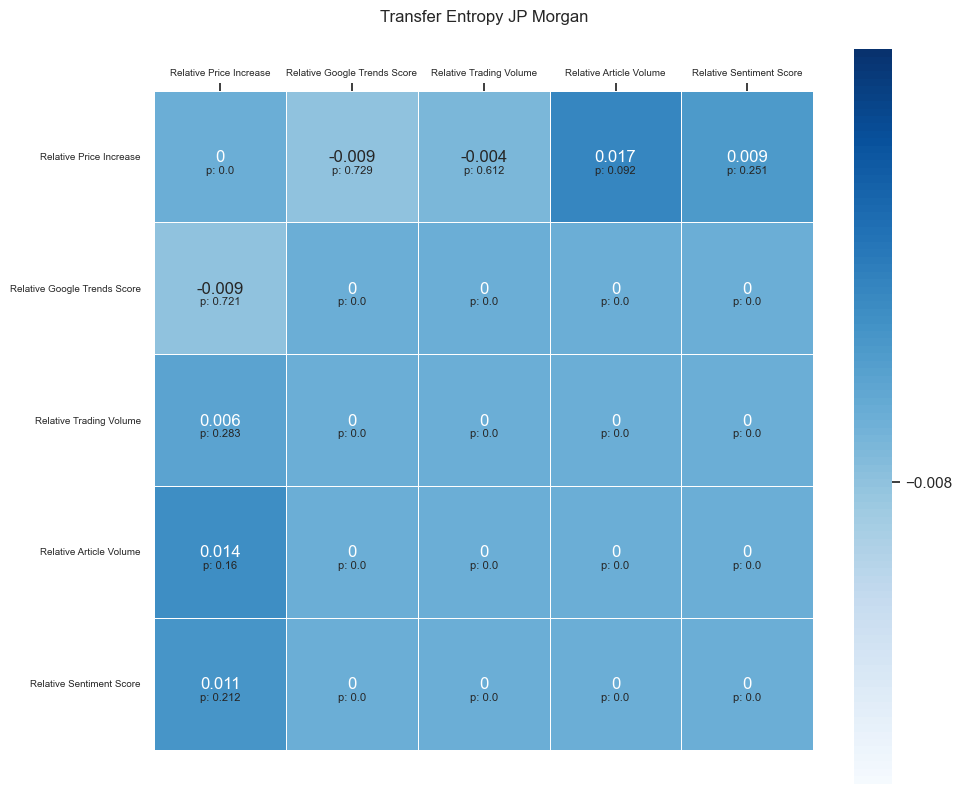

Parameter p: 4
-0.008125


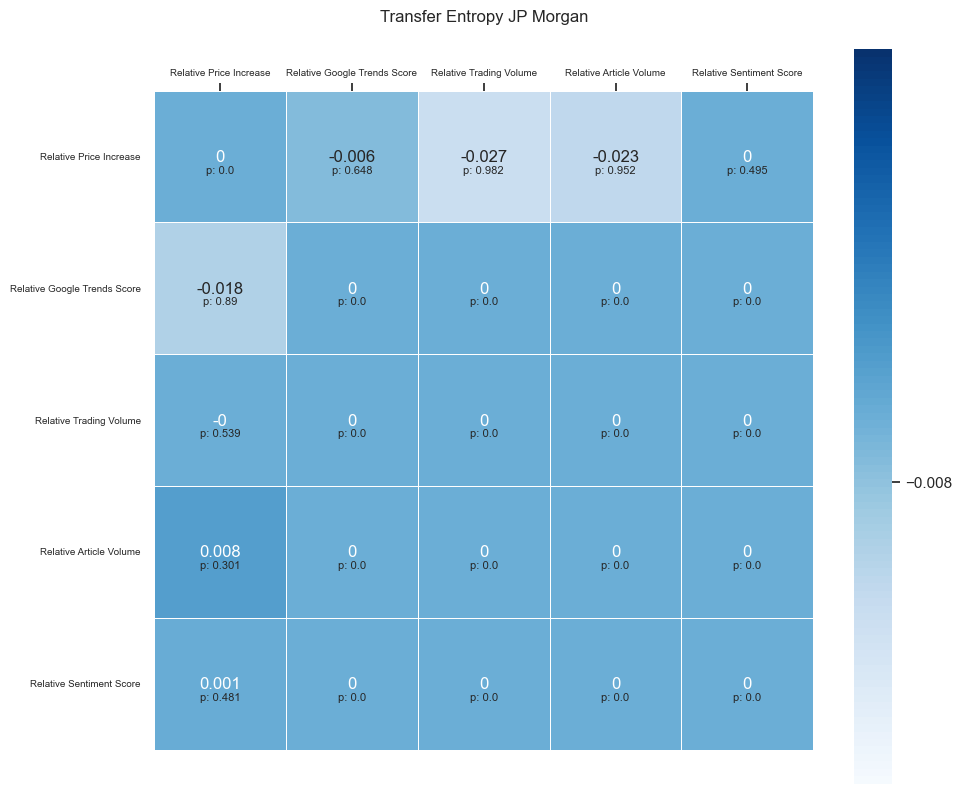

Parameter p: 7
-0.0025


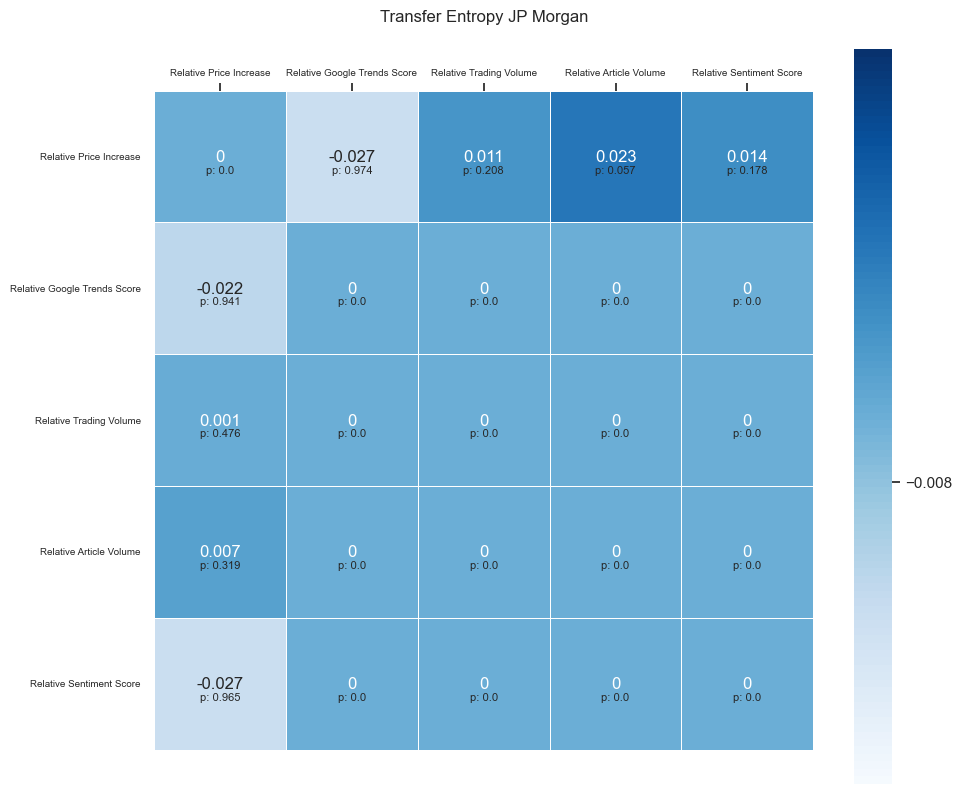

Parameter p: 10
0.0022499999999999985


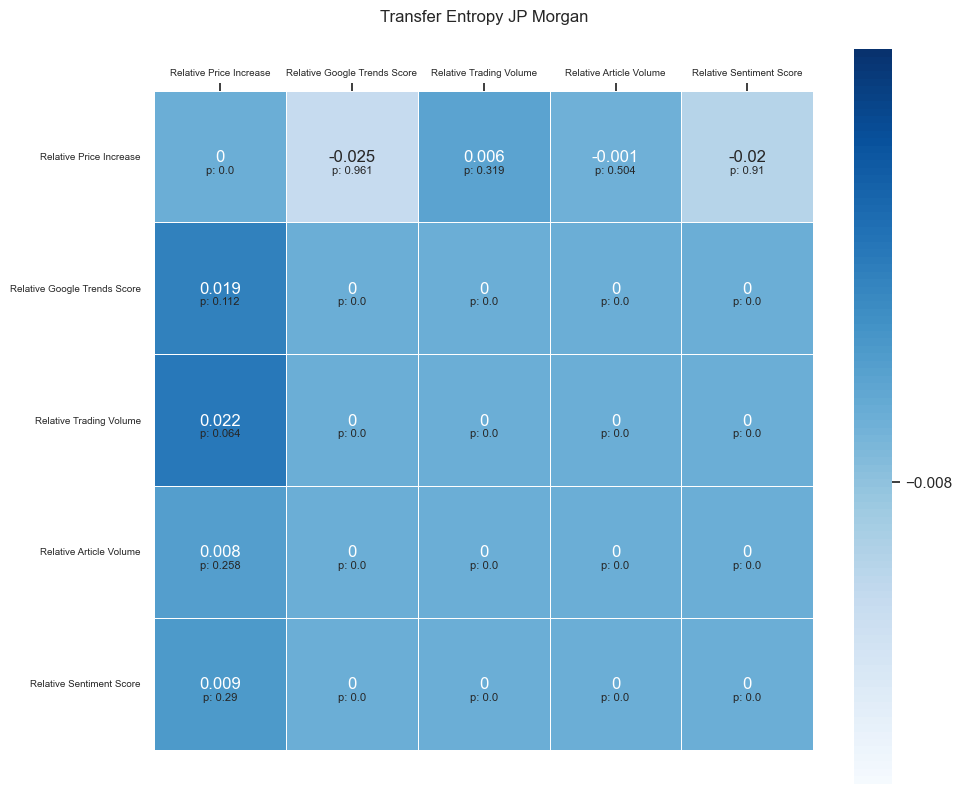

Parameter p: 13
-0.0006249999999999999


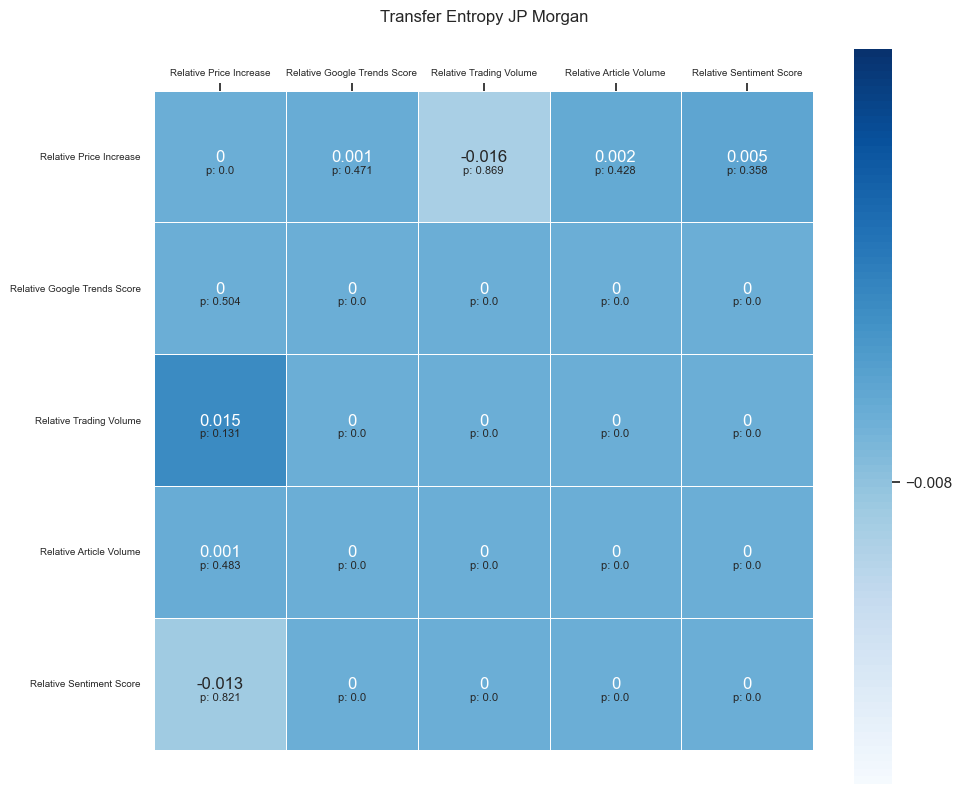

Parameter p: 1
0.0035000000000000005


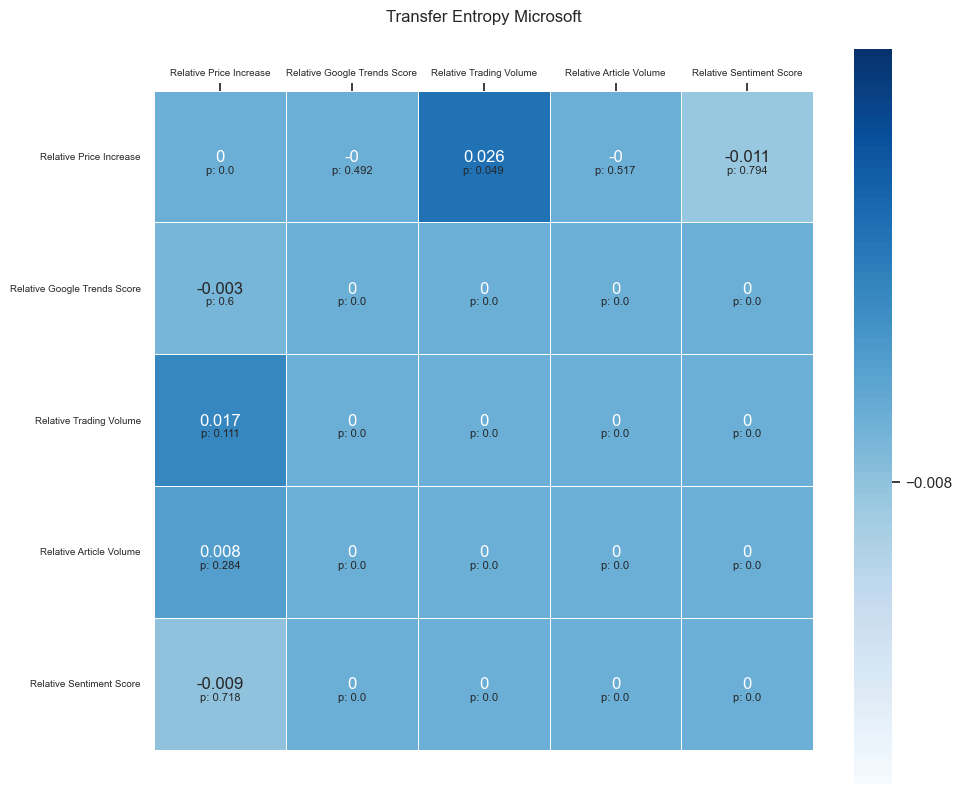

Parameter p: 4
0.0022500000000000003


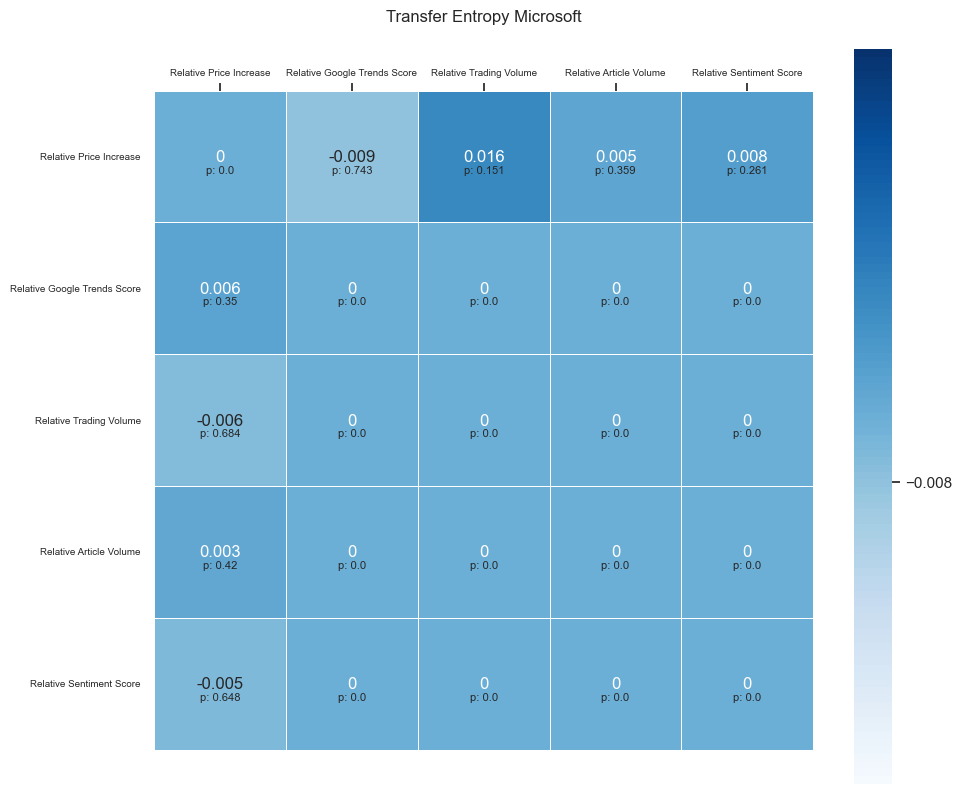

Parameter p: 7
0.0032500000000000003


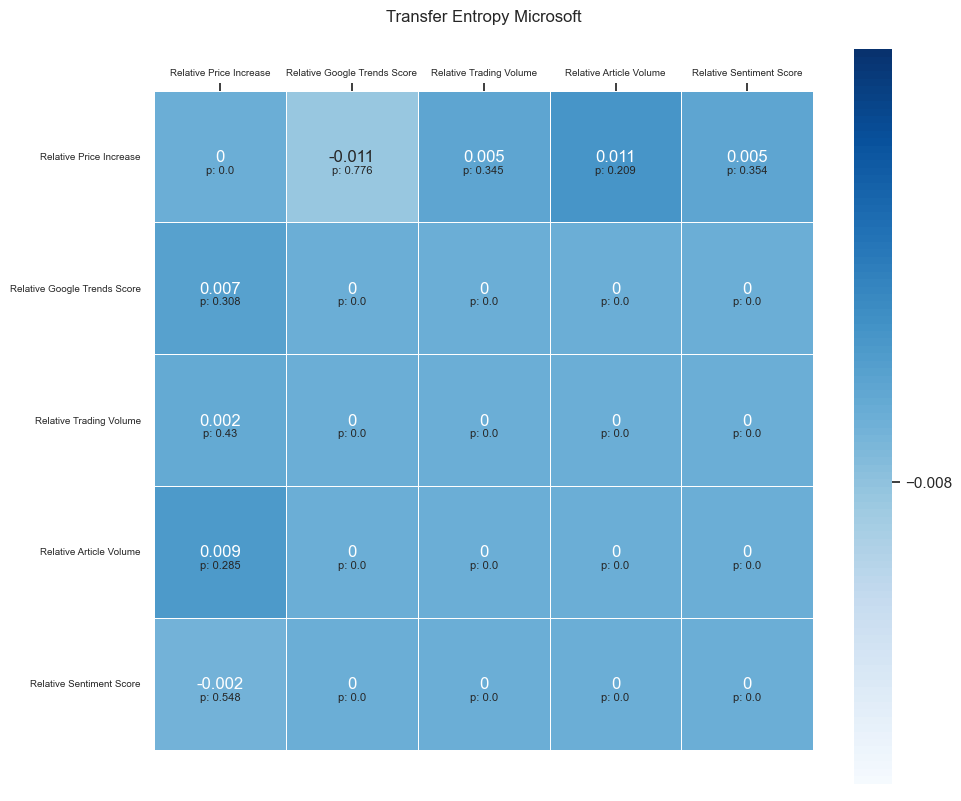

Parameter p: 10
-0.0006249999999999997


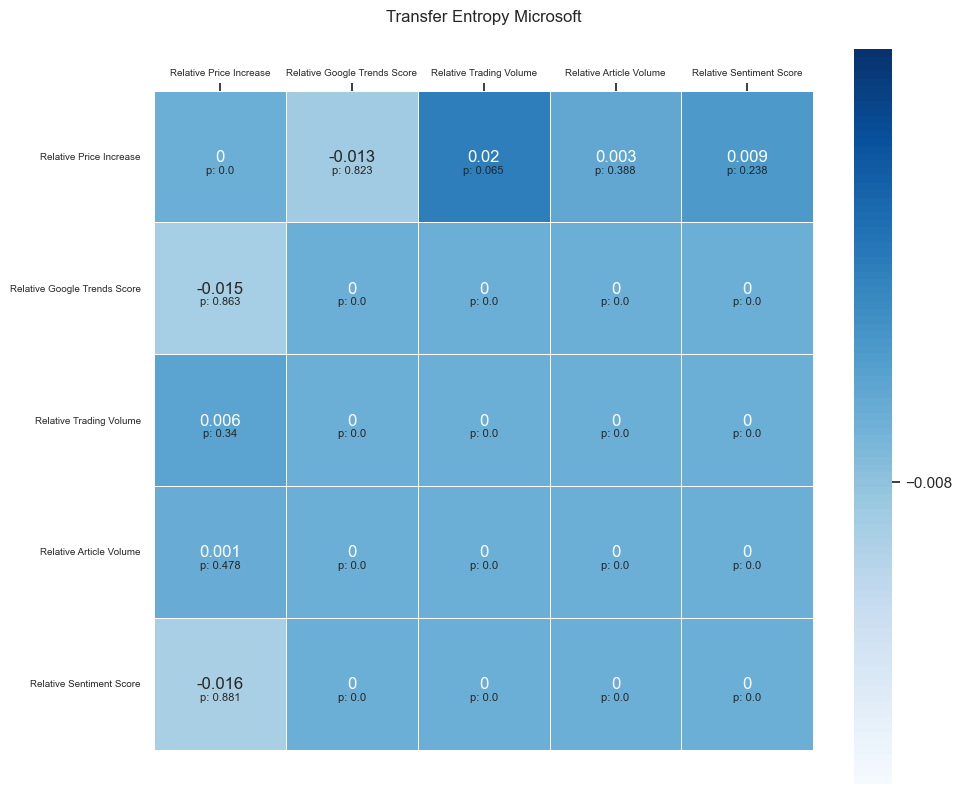

Parameter p: 13
0.0085


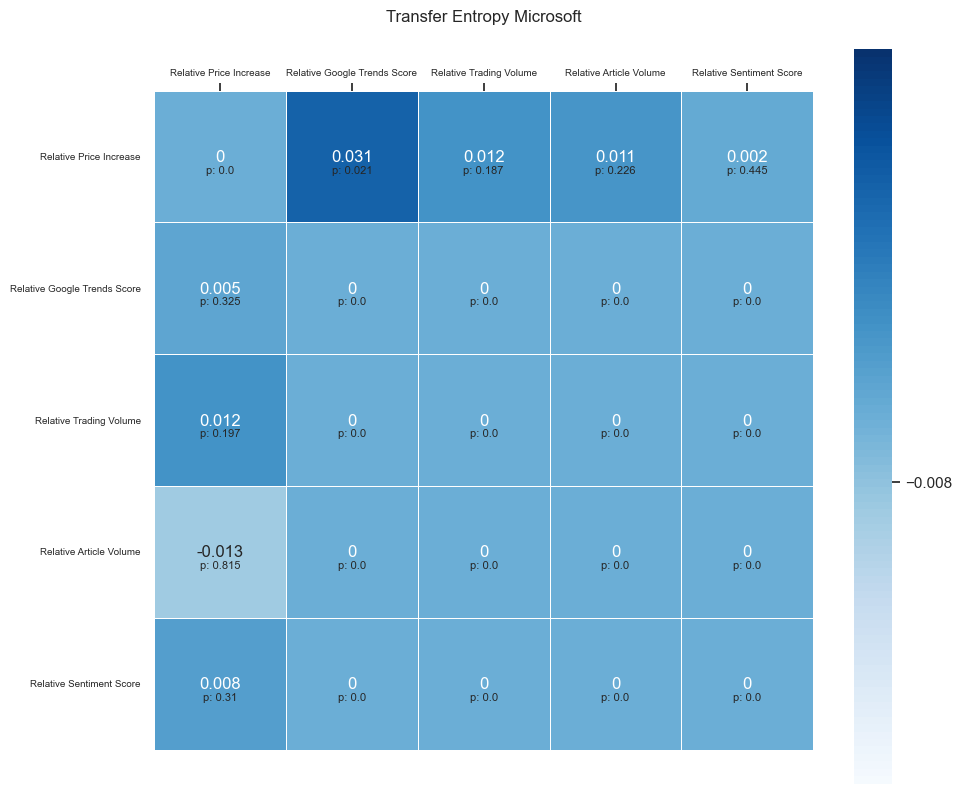

Parameter p: 1
0.00012500000000000054


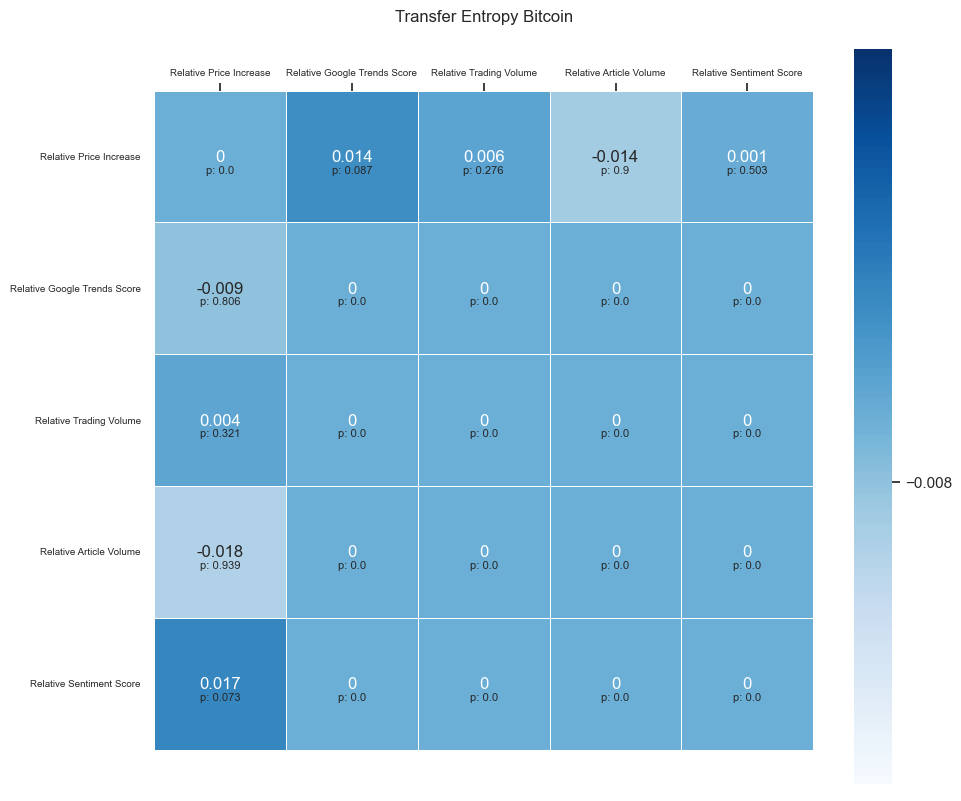

Parameter p: 4
0.004125


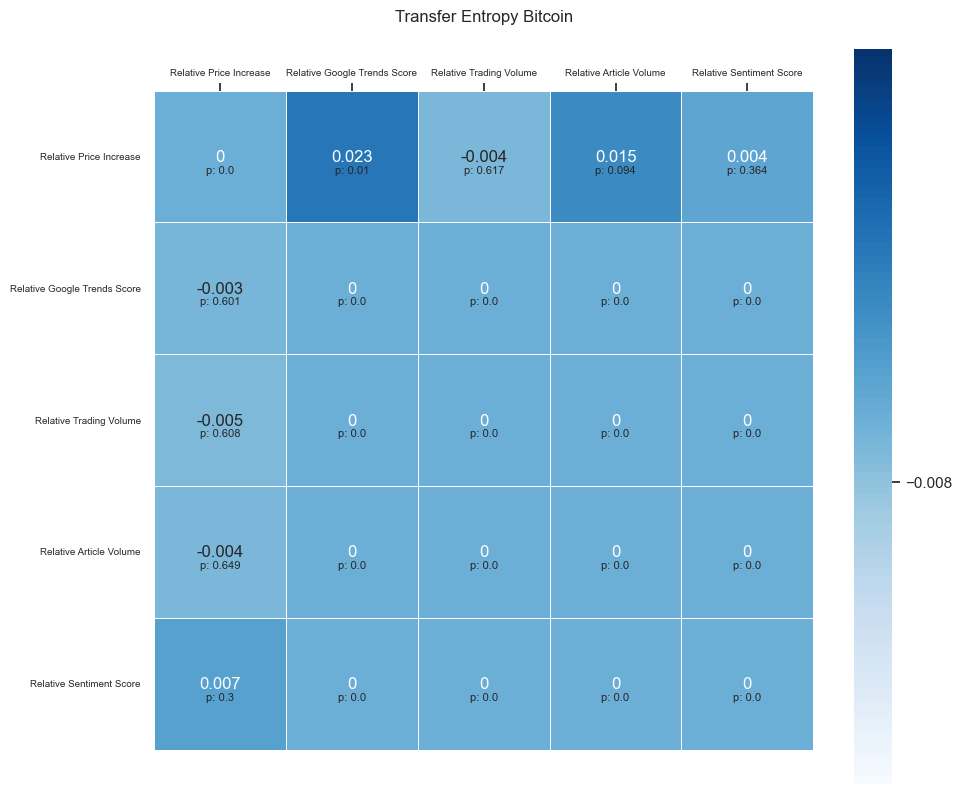

Parameter p: 7
-0.004


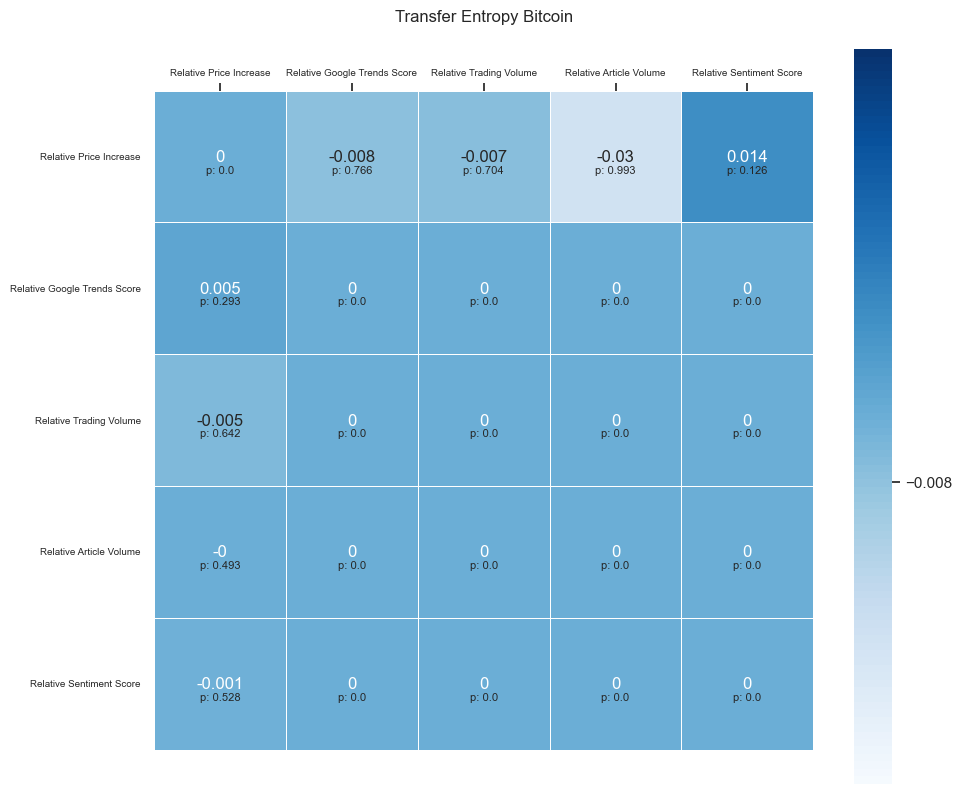

Parameter p: 10
0.0028750000000000004


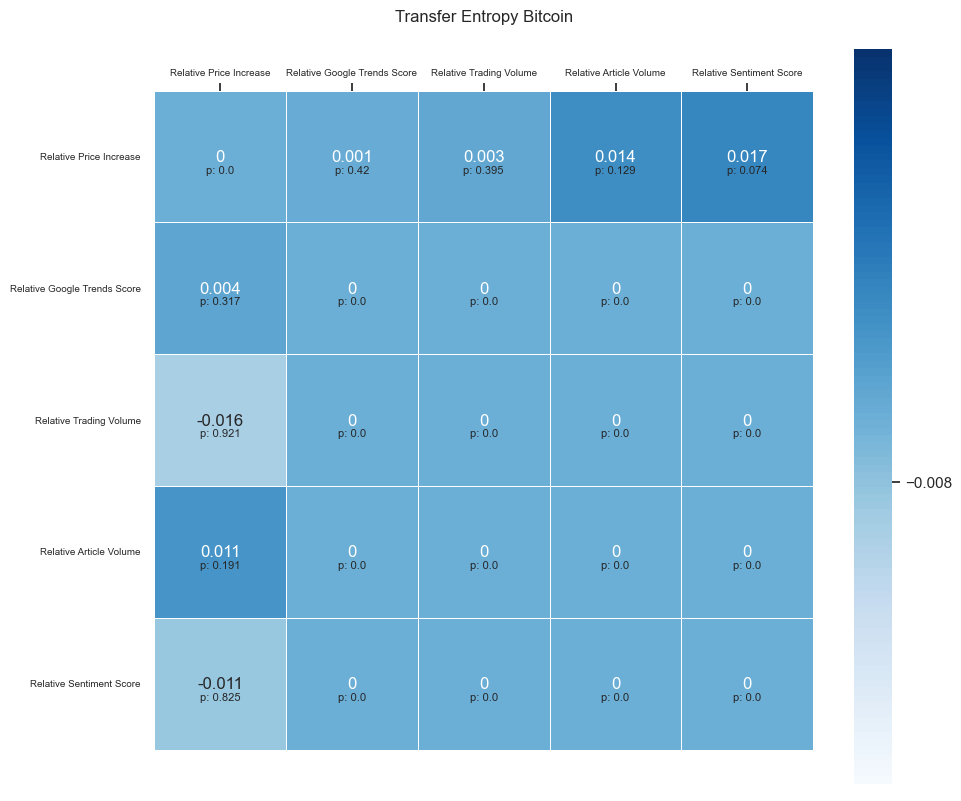

Parameter p: 13
0.003


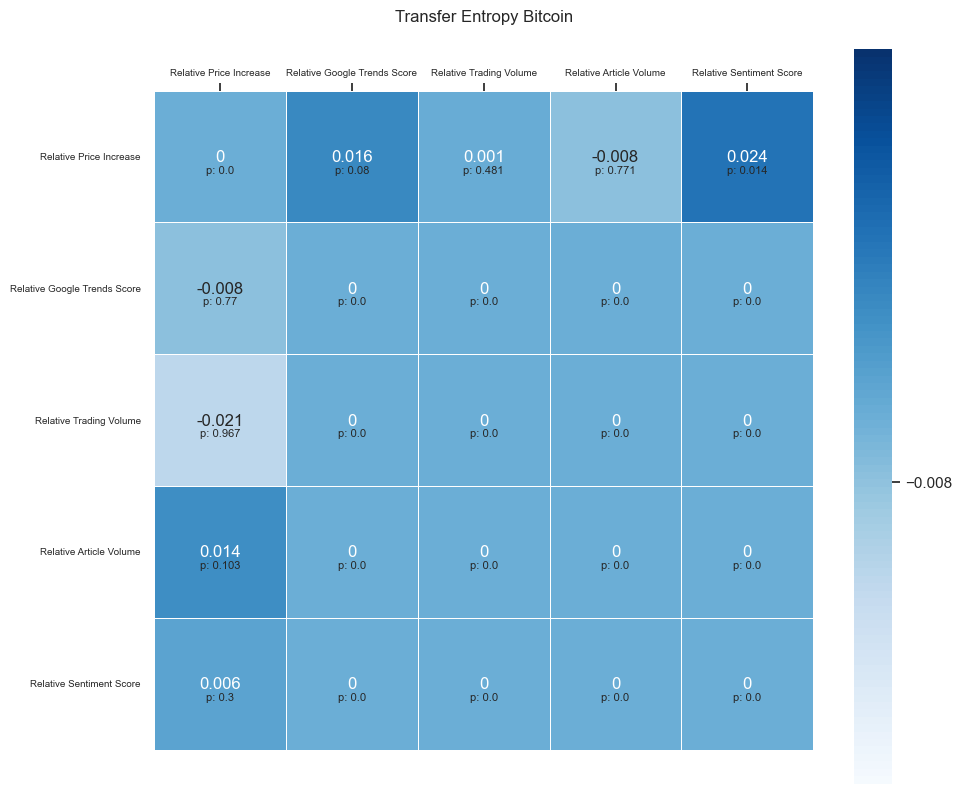

Parameter a: 2
Parameter p: 1
0.0032500000000000003


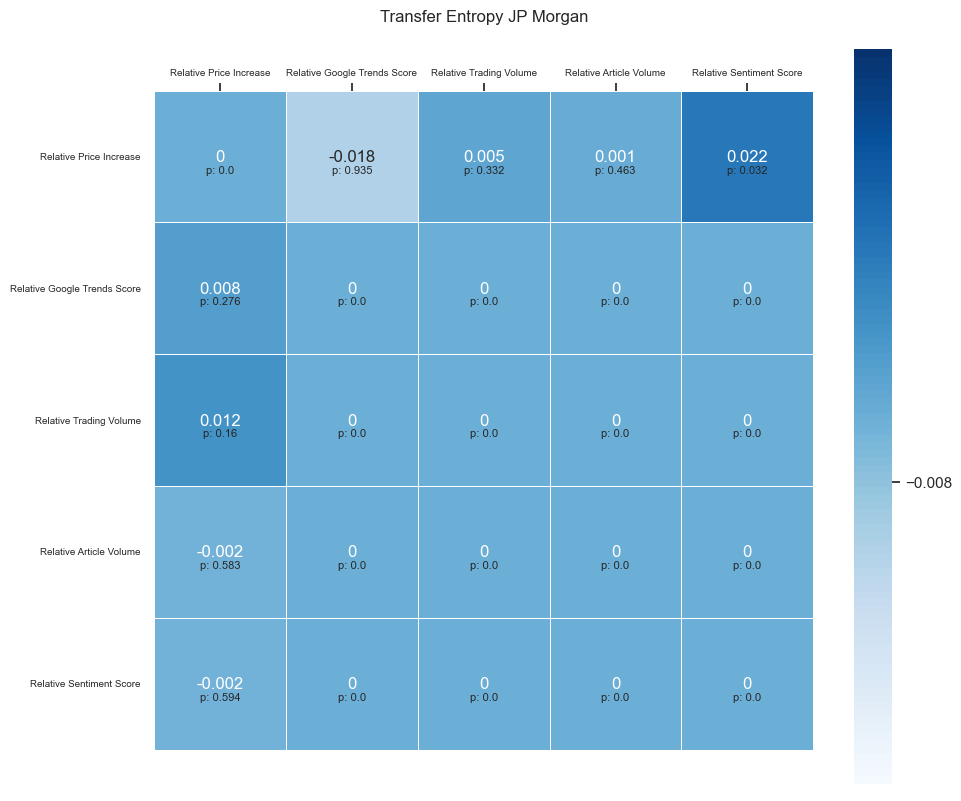

Parameter p: 4
0.0023749999999999995


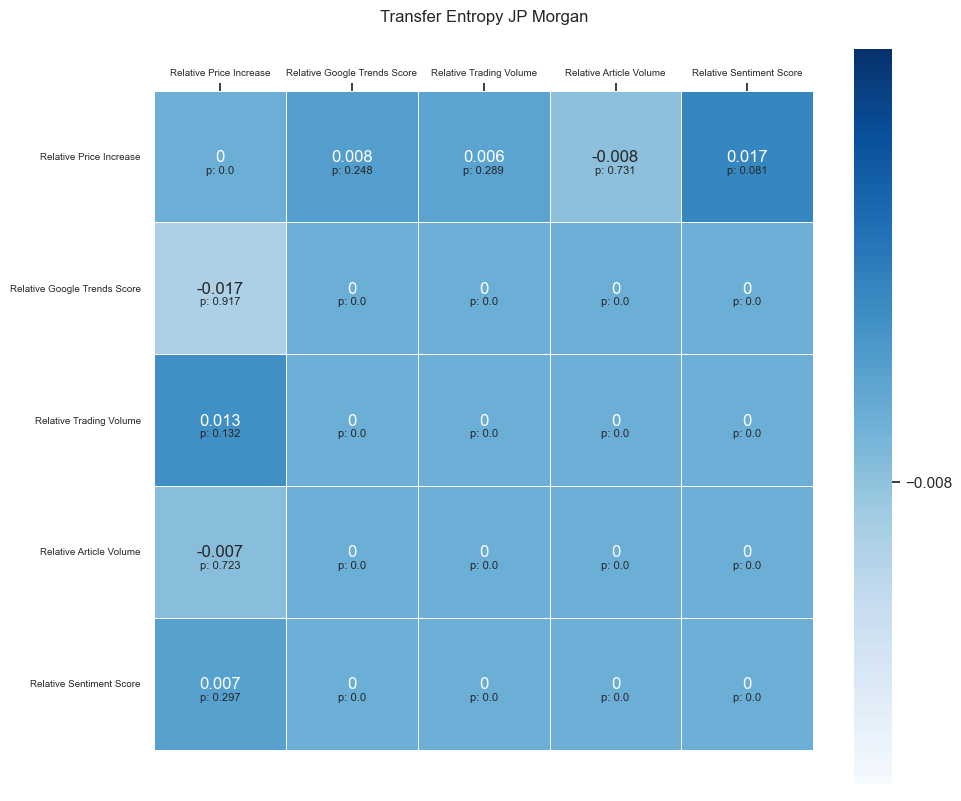

Parameter p: 7
0.0026249999999999997


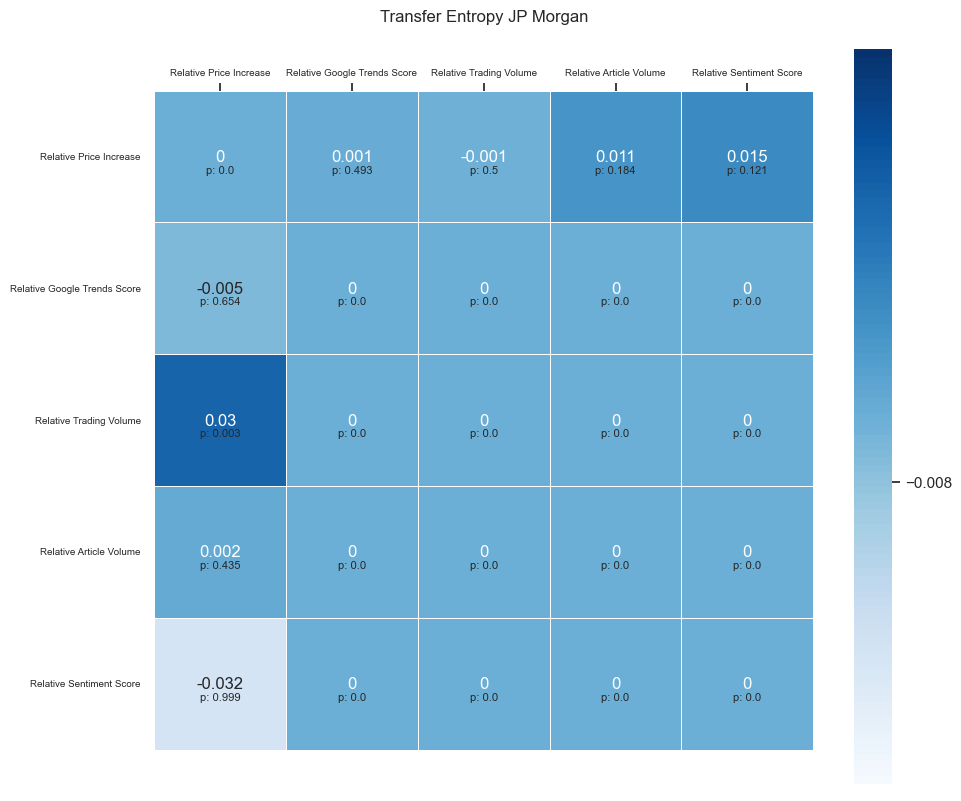

Parameter p: 10
0.0008750000000000003


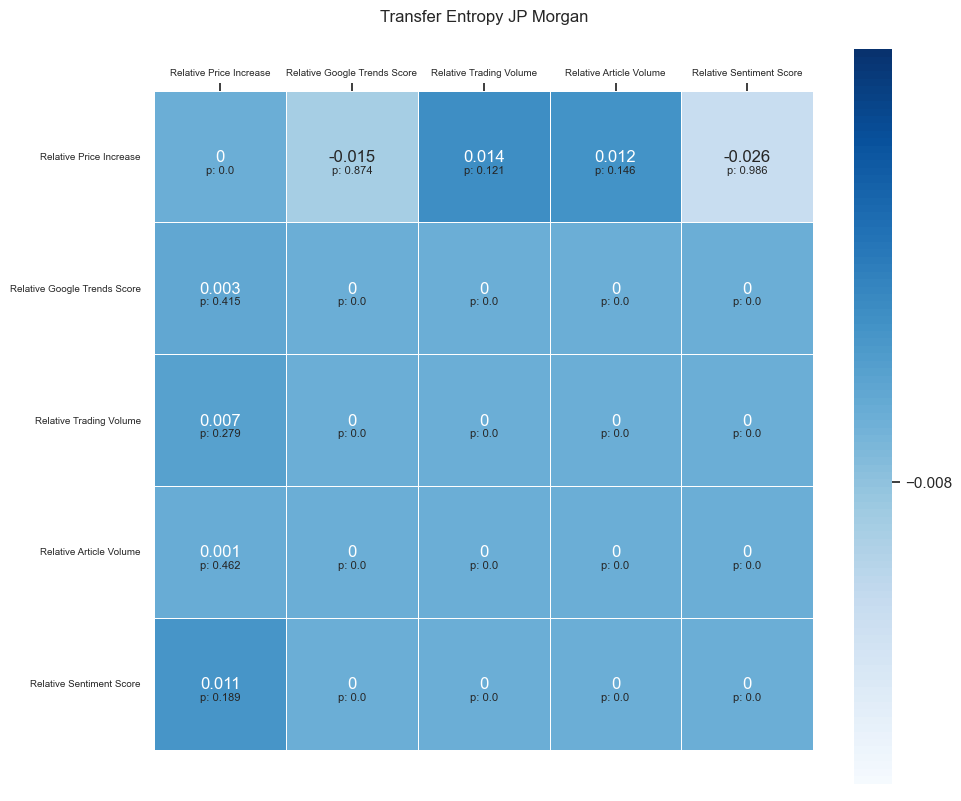

Parameter p: 13
0.001125


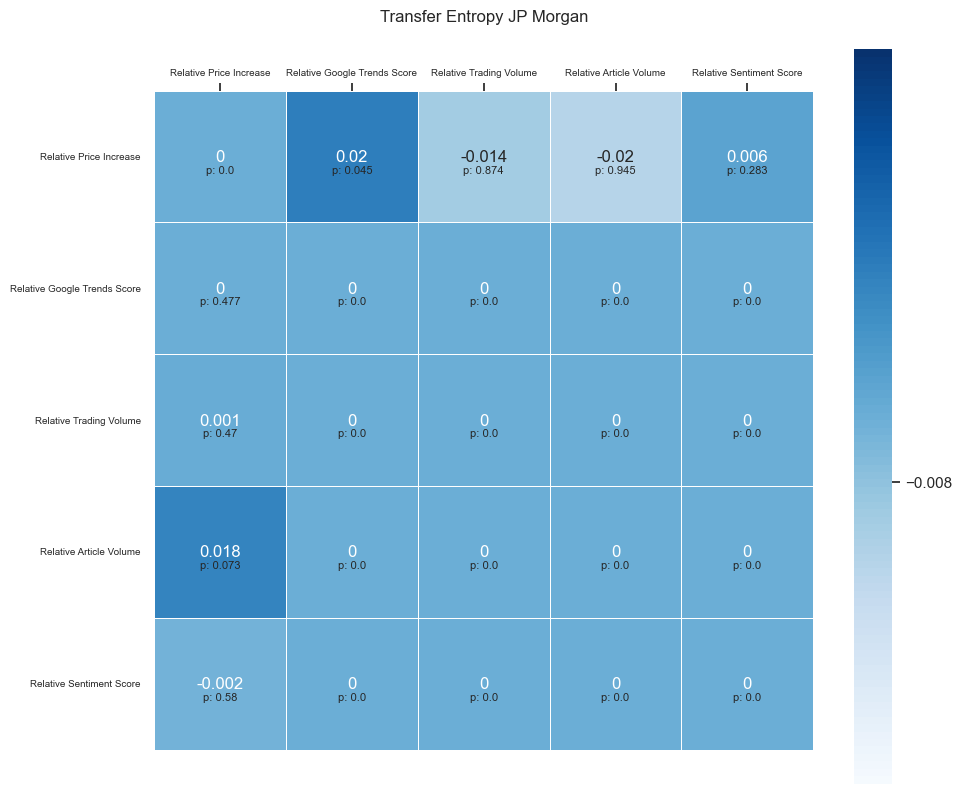

Parameter p: 1
-0.0017500000000000003


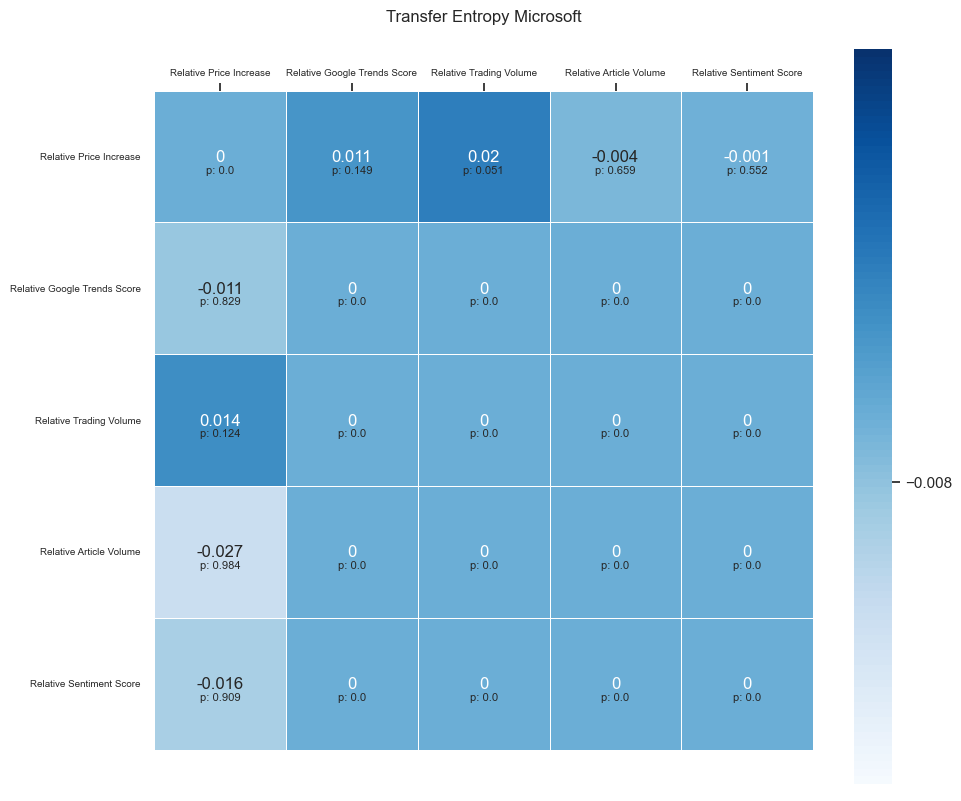

Parameter p: 4
0.003000000000000001


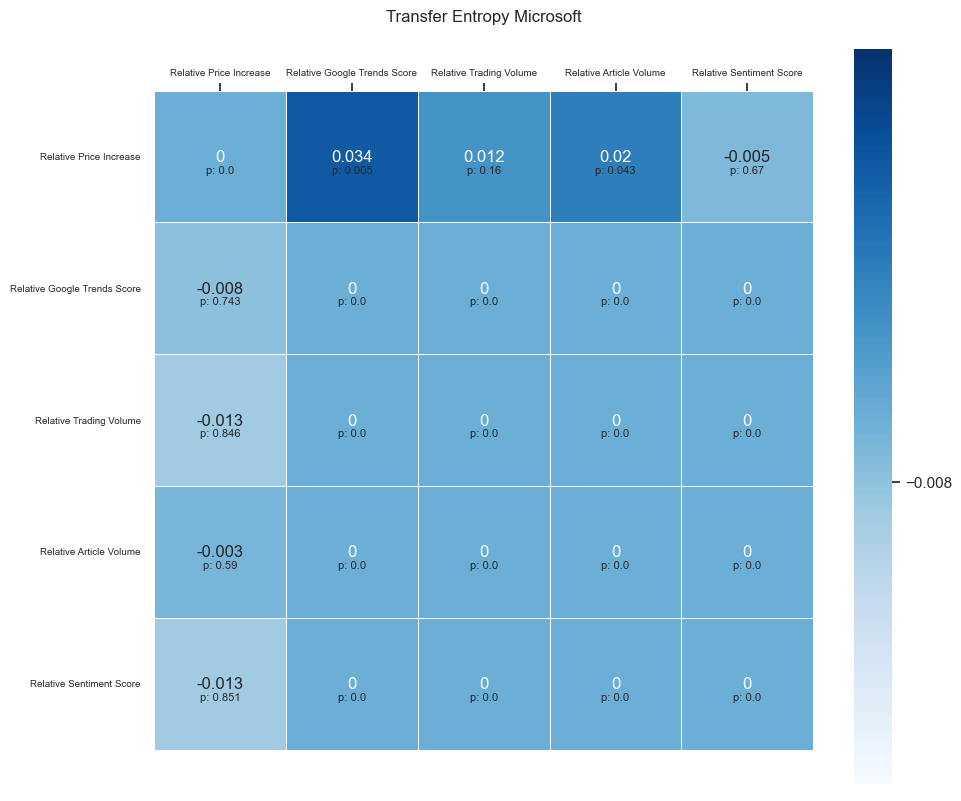

Parameter p: 7
0.0033750000000000004


Parameter p: 10
-0.004874999999999999


Parameter p: 13
0.0075000000000000015


Parameter p: 1
0.004874999999999999


Parameter p: 4
0.00575


Parameter p: 7
-1.0842021724855044e-19


Parameter p: 10
0.00425


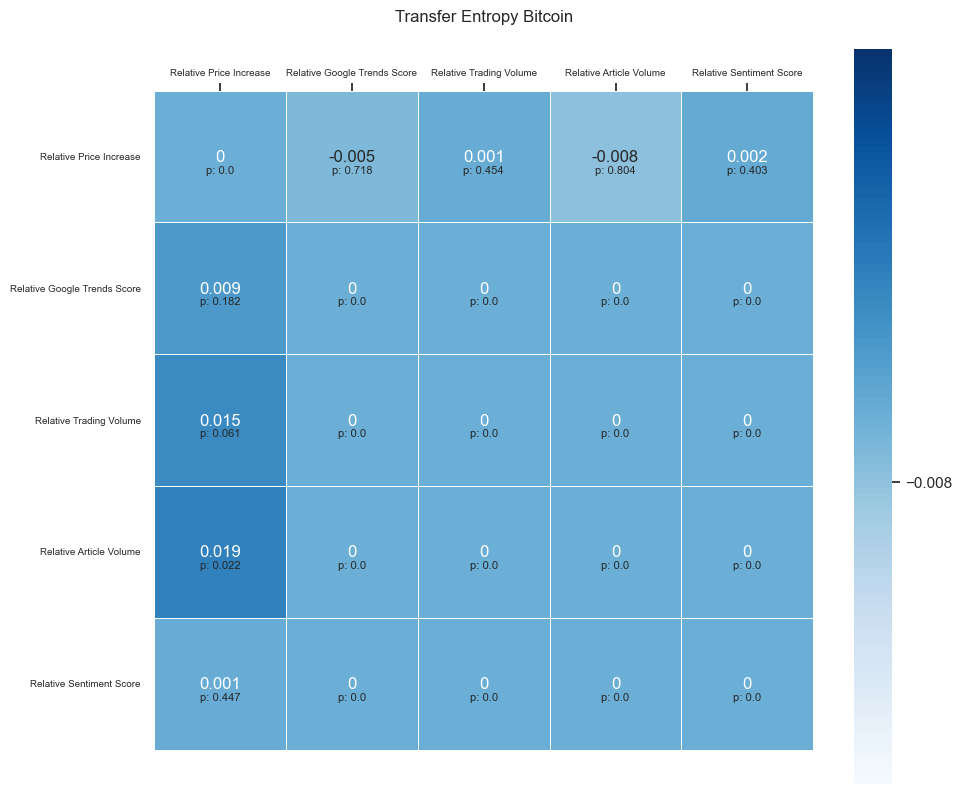

Parameter p: 13
0.00425


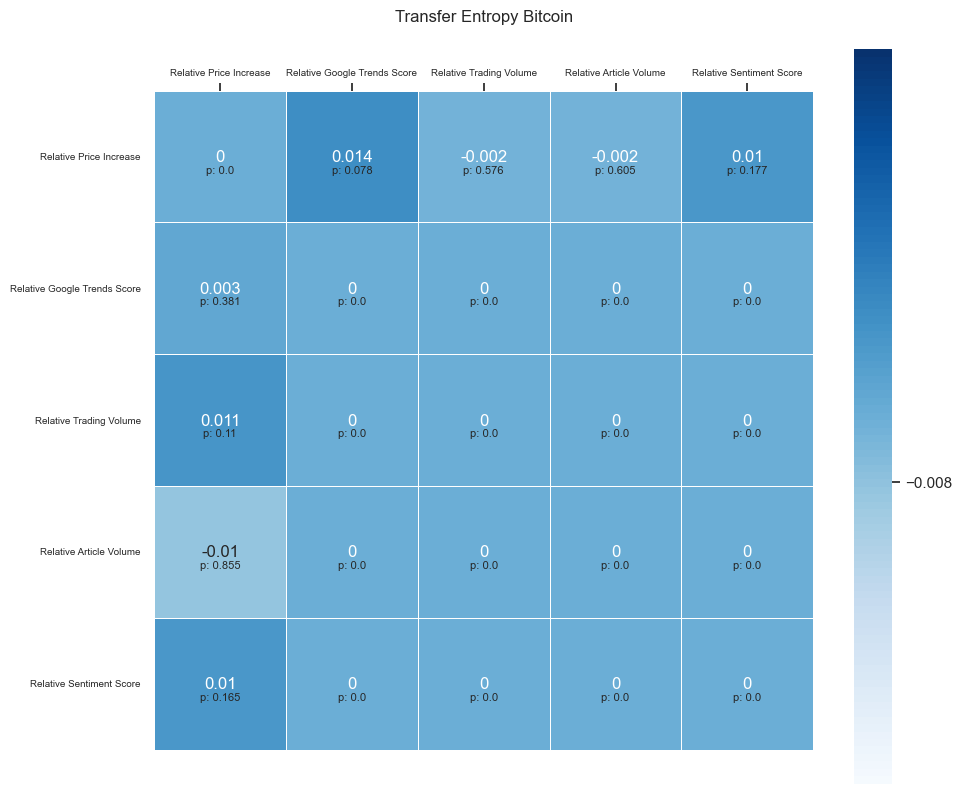

In [48]:
# find most optimal parameters for high transfer entropy
from matplotlib.colors import Normalize, LinearSegmentedColormap
dataset = [5, 6, 2] # one dataset for each asset class (jp morgan, microsoft, bitcoin)
# test first paramter "k" in range of 1,2
for a in range(2):
    print("Parameter a: " + str(a+1))
    # for every test-dataset 
    for i in dataset:
        # test coupling delay
        for p in range(1, 16, 3):
            print("Parameter p: " + str(p))
            
            a_a = [0,0]
            a_b = TE_X_to_Y_matrix(data[i][keys[0]], data[i][keys[1]],keys[0], keys[1], [a+1,1,1,1,p])
            a_c = TE_X_to_Y_matrix(data[i][keys[0]], data[i][keys[2]],keys[0], keys[2], [a+1,1,1,1,p])
            a_d = TE_X_to_Y_matrix(data[i][keys[0]], data[i][keys[3]],keys[0], keys[3], [a+1,1,1,1,p])
            a_e = TE_X_to_Y_matrix(data[i][keys[0]], data[i][keys[4]],keys[0], keys[4], [a+1,1,1,1,p])

            b_a = TE_X_to_Y_matrix(data[i][keys[1]], data[i][keys[0]],keys[1], keys[0], [a+1,1,1,1,p])
            b_b = [0,0]
            b_c = [0,0]
            b_d = [0,0]
            b_e = [0,0]

            c_a = TE_X_to_Y_matrix(data[i][keys[2]], data[i][keys[0]],keys[2], keys[0], [a+1,1,1,1,p])
            c_b = [0,0]
            c_c = [0,0]
            c_d = [0,0]
            c_e = [0,0]

            d_a = TE_X_to_Y_matrix(data[i][keys[3]], data[i][keys[0]],keys[3], keys[0], [a+1,1,1,1,p])
            d_b = [0,0]
            d_c = [0,0]
            d_d = [0,0]
            d_e = [0,0]

            e_a = TE_X_to_Y_matrix(data[i][keys[4]], data[i][keys[0]],keys[4], keys[0], [a+1,1,1,1,p])
            e_b = [0,0]
            e_c = [0,0]
            e_d = [0,0]
            e_e = [0,0]

            TE_values = np.array([
                [a_a[0], a_b[0], a_c[0], a_d[0], a_e[0]],
                [b_a[0], b_b[0], b_c[0], b_d[0], b_e[0]],
                [c_a[0], c_b[0], c_c[0], c_d[0], c_e[0]],
                [d_a[0], d_b[0], d_c[0], d_d[0], d_e[0]],
                [e_a[0], e_b[0], e_c[0], e_d[0], e_e[0]]
            ])

            TE_p_values = np.array([
                [a_a[1], a_b[1], a_c[1], a_d[1], a_e[1]],
                [b_a[1], b_b[1], b_c[1], b_d[1], b_e[1]],
                [c_a[1], c_b[1], c_c[1], c_d[1], c_e[1]],
                [d_a[1], d_b[1], d_c[1], d_d[1], d_e[1]],
                [e_a[1], e_b[1], e_c[1], e_d[1], e_e[1]]
            ])

            # print average entropy value
            print((a_b[0]+a_c[0]+a_d[0]+a_e[0]+b_a[0]+c_a[0]+d_a[0]+e_a[0])/8)

            num_bins = 100
            blue_gradient = sns.color_palette("Blues", num_bins)
            blue_gradient.insert(0, (1, 1, 1))  # insert white at the beginning for -0.1
            custom_cmap_visible = LinearSegmentedColormap.from_list('custom_blue', blue_gradient, N=num_bins)
            norm = Normalize(vmin=-0.05, vmax=0.05)  # Normalizing from -0.1 to 0.05 (0.05 is a bit more than the highest TE value observed - setting it to a fixed value allows for more easy graphical interpretation among different stocks / crypto currenceis)

            # Plotting
            sns.set(style="white")
            plt.figure(figsize=(10, 8))
            heatmap = sns.heatmap(TE_values, cmap=custom_cmap_visible, norm=norm, annot=True, xticklabels=keys, yticklabels=keys,
                                cbar_kws={"ticks": np.linspace(-0.1, 1, 13)}, linewidths=.5, square=True)
            heatmap.tick_params(axis='x', labelsize=7)
            heatmap.tick_params(axis='y', labelsize=7)  # Adjust fontsize for y-axis labels as well
            
            for x in range(TE_values.shape[0]):
                for y in range(TE_values.shape[1]):
                    plt.annotate(text="p: "+str(TE_p_values[x][y]), xy=(y+0.5 , x +0.6),  ha='center', va='center', fontsize=8)


            # Move the x-axis to the top of the figure
            heatmap.xaxis.tick_top()
            heatmap.xaxis.set_label_position('top')

            # Adjust the x-axis labels to be horizontal and for two lines
            plt.xticks(rotation=0, ha='center')
            plt.yticks(rotation=0)
            heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize=7)
            plt.tight_layout()

            plt.title(f'Transfer Entropy {asset_keyword[i]}', pad=50)

            # Show the plot
            plt.show()


### Final run

[[ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]]
[[ 0.007  0.002  0.005 -0.003  0.015]
 [-0.007 -0.009  0.012 -0.008 -0.01 ]
 [-0.007 -0.009  0.008 -0.008 -0.022]
 [ 0.001 -0.013 -0.011 -0.009 -0.016]
 [ 0.003 -0.006  0.009 -0.019 -0.015]]
[[0.297 0.458 0.285 0.575 0.095]
 [0.738 0.774 0.152 0.762 0.809]
 [0.712 0.787 0.246 0.769 0.968]
 [0.5   0.857 0.835 0.762 0.92 ]
 [0.434 0.687 0.225 0.952 0.888]]


C:\Users\franz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\franz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


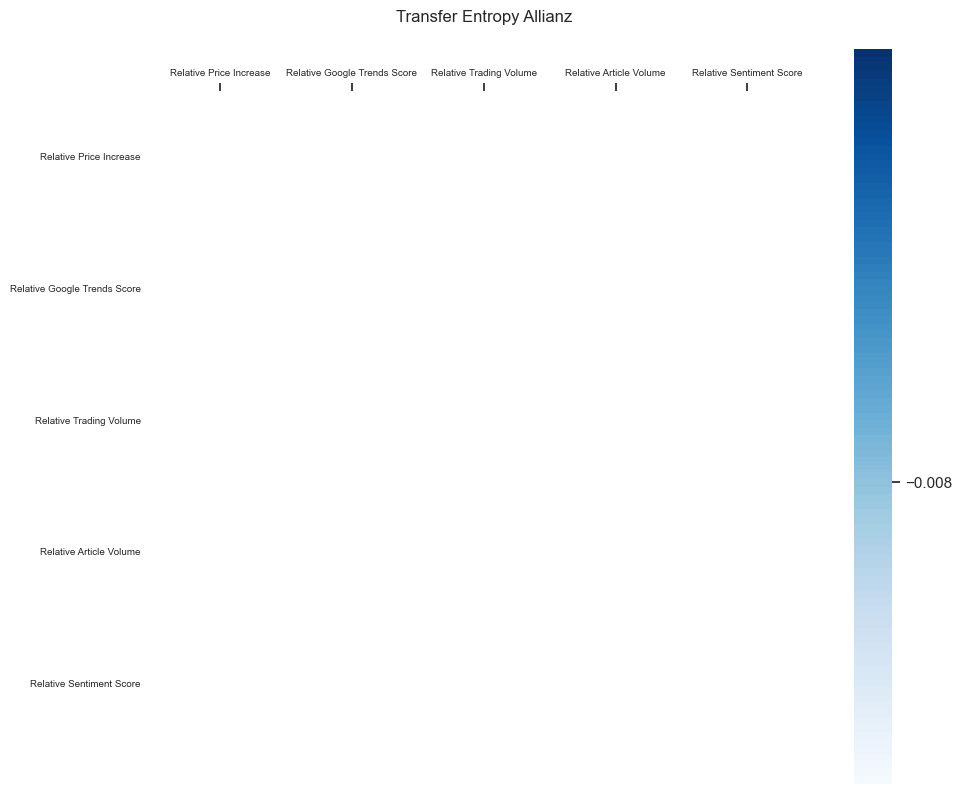

[[ True  True  True  True  True]
 [False  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]]
[[ 0.017  0.001 -0.004 -0.013 -0.001]
 [ 0.025 -0.008 -0.001 -0.005 -0.012]
 [-0.01  -0.005 -0.01   0.005  0.008]
 [-0.005  0.005  0.004  0.     0.005]
 [-0.015  0.01  -0.01  -0.001 -0.029]]
[[0.088 0.448 0.656 0.849 0.519]
 [0.017 0.728 0.532 0.634 0.847]
 [0.796 0.644 0.815 0.311 0.255]
 [0.706 0.308 0.333 0.446 0.32 ]
 [0.893 0.17  0.798 0.508 0.994]]


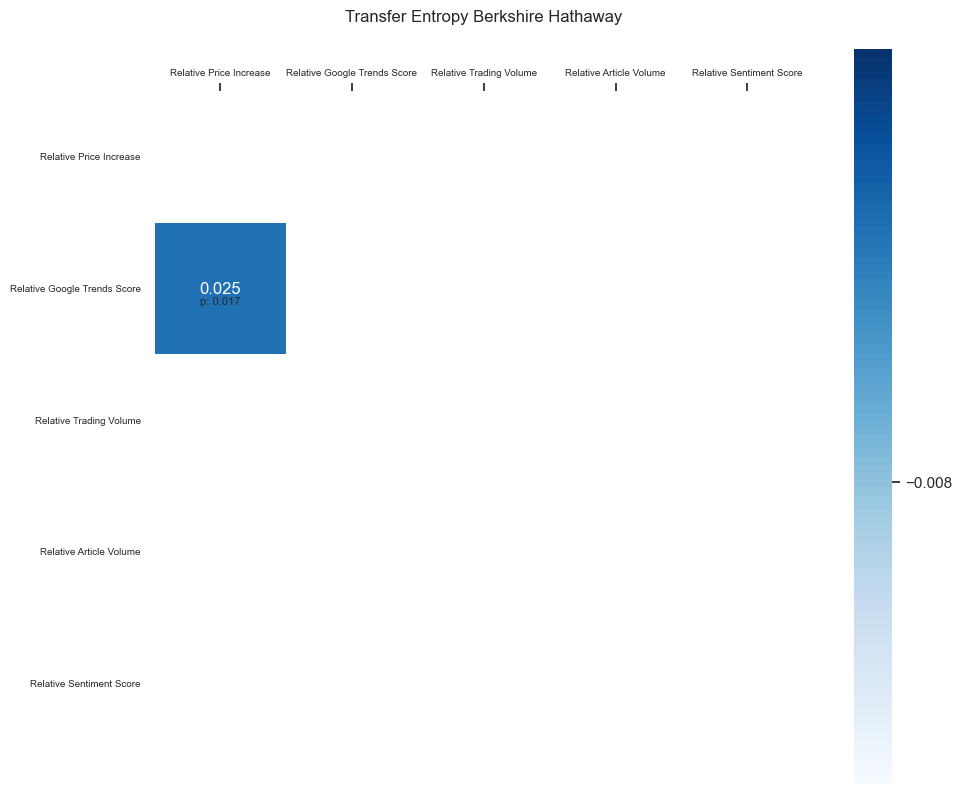

[[ True  True  True  True  True]
 [ True  True False  True  True]
 [ True False  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]]
[[ 0.014 -0.009 -0.005  0.001 -0.002]
 [ 0.006  0.022  0.017  0.011  0.007]
 [ 0.004  0.03   0.046  0.01   0.006]
 [ 0.004  0.013  0.009  0.019  0.01 ]
 [ 0.001 -0.    -0.01   0.008 -0.006]]
[[0.076 0.844 0.688 0.495 0.58 ]
 [0.254 0.007 0.028 0.114 0.219]
 [0.316 0.001 0.    0.131 0.252]
 [0.332 0.076 0.134 0.019 0.145]
 [0.471 0.514 0.861 0.198 0.698]]


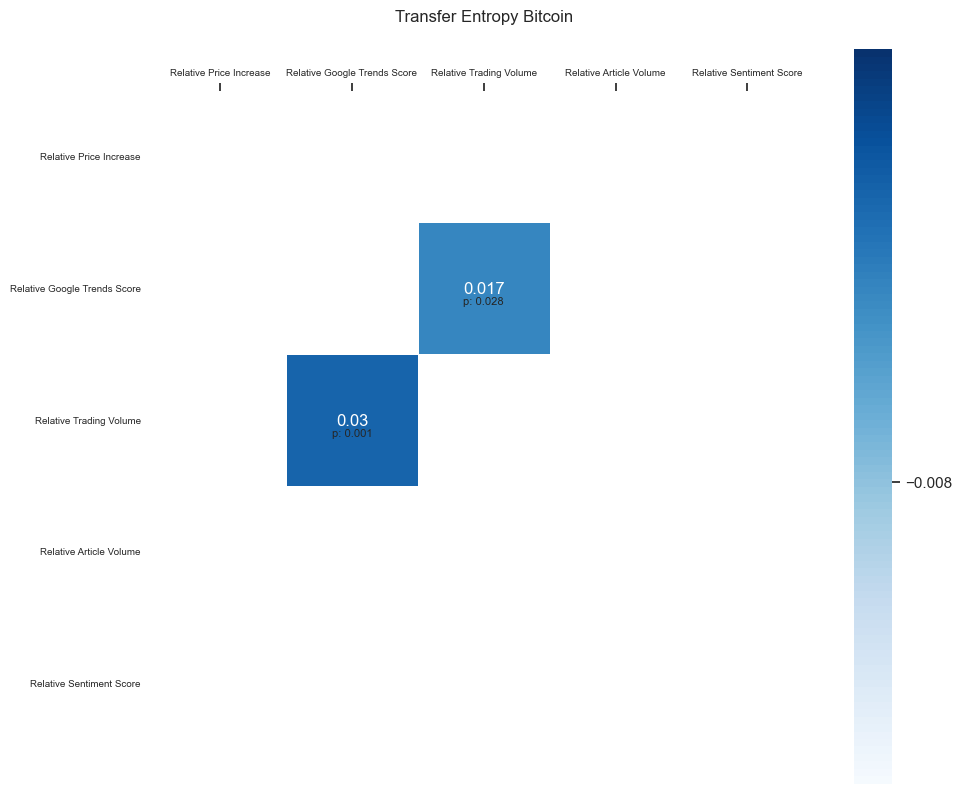

[[ True  True False  True  True]
 [ True  True  True  True  True]
 [False  True  True False False]
 [ True  True  True  True  True]
 [ True  True False  True  True]]
[[ 0.014  0.006  0.014 -0.006 -0.016]
 [ 0.004 -0.01  -0.004  0.006  0.001]
 [ 0.016  0.006  0.02   0.026  0.021]
 [-0.011  0.004  0.009  0.023 -0.012]
 [-0.007 -0.001  0.019  0.004 -0.009]]
[[0.086 0.078 0.03  0.749 0.937]
 [0.167 0.841 0.828 0.117 0.326]
 [0.015 0.085 0.004 0.    0.001]
 [0.866 0.316 0.123 0.007 0.869]
 [0.734 0.586 0.005 0.347 0.795]]


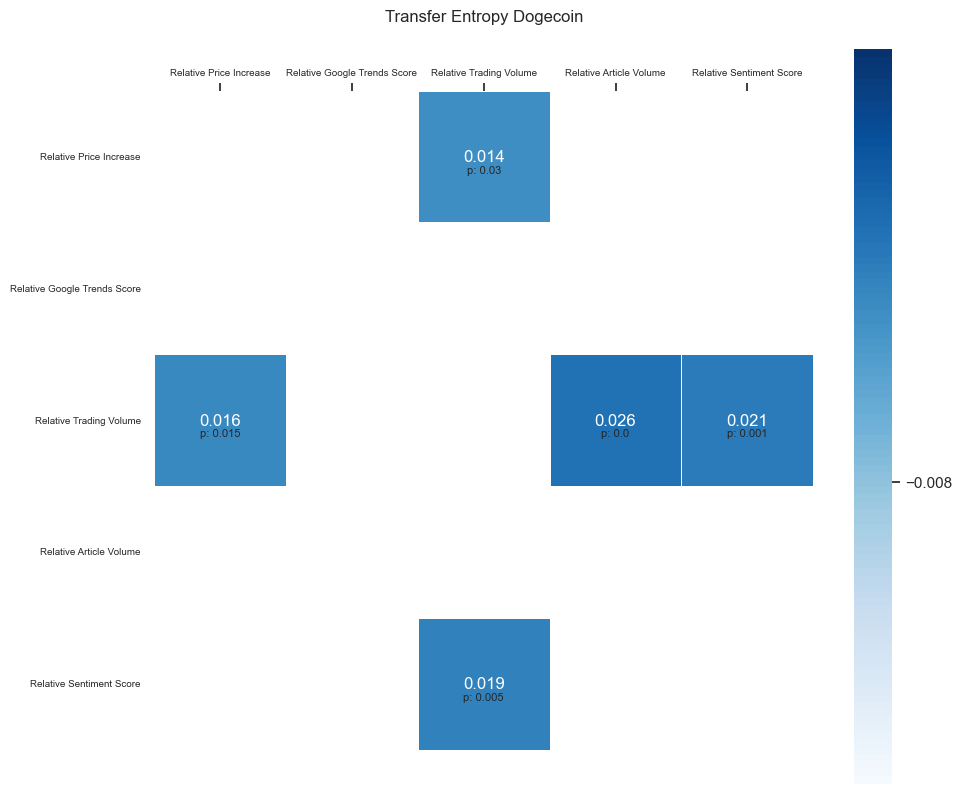

[[ True  True  True  True False]
 [ True  True False  True  True]
 [ True  True  True  True  True]
 [ True False  True  True  True]
 [ True False  True  True  True]]
[[-0.011 -0.001 -0.009  0.007  0.018]
 [ 0.005  0.008  0.019  0.017  0.016]
 [ 0.01  -0.008  0.035  0.008  0.006]
 [-0.001  0.018  0.01   0.054  0.015]
 [-0.02   0.018 -0.003  0.002 -0.009]]
[[0.841 0.556 0.833 0.225 0.041]
 [0.348 0.22  0.018 0.054 0.053]
 [0.145 0.828 0.    0.206 0.283]
 [0.505 0.029 0.142 0.    0.062]
 [0.975 0.028 0.637 0.413 0.799]]


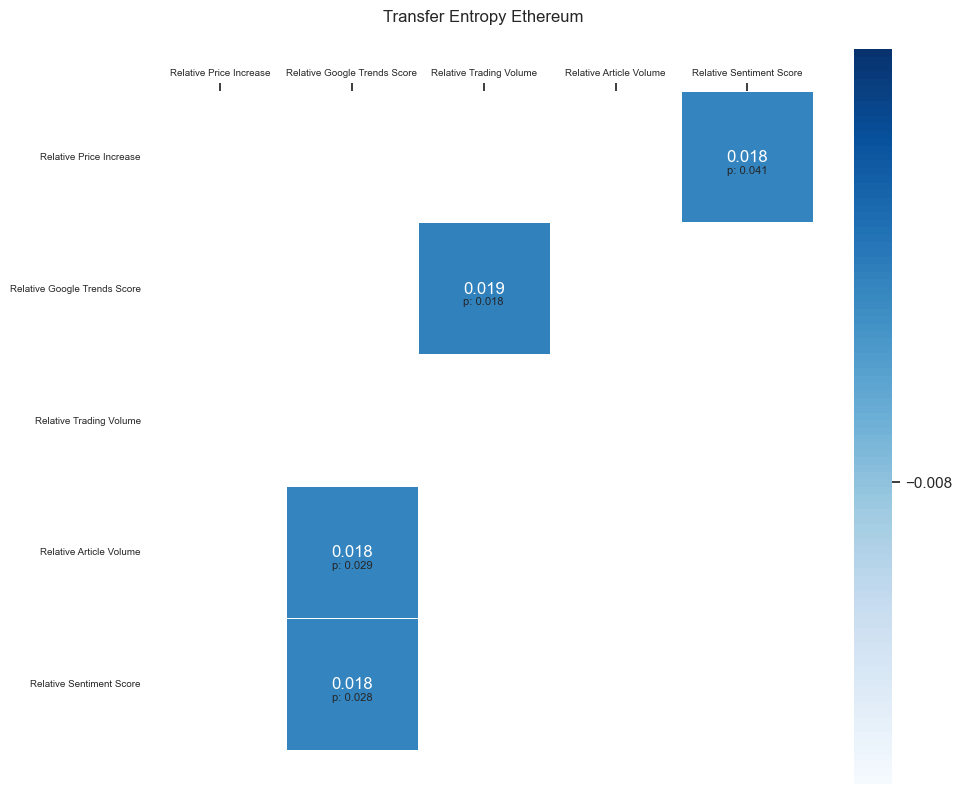

[[ True  True  True  True  True]
 [ True  True  True  True  True]
 [False  True  True  True  True]
 [ True  True False  True  True]
 [ True  True  True  True  True]]
[[ 0.004 -0.007 -0.001  0.011  0.015]
 [-0.005 -0.008  0.005 -0.007  0.006]
 [ 0.03  -0.022  0.001 -0.001 -0.012]
 [ 0.002 -0.009  0.025  0.007  0.011]
 [-0.032  0.01   0.003 -0.013 -0.003]]
[[0.356 0.728 0.505 0.172 0.103]
 [0.631 0.769 0.341 0.719 0.302]
 [0.006 0.97  0.439 0.494 0.83 ]
 [0.474 0.787 0.008 0.285 0.152]
 [1.    0.218 0.373 0.867 0.577]]


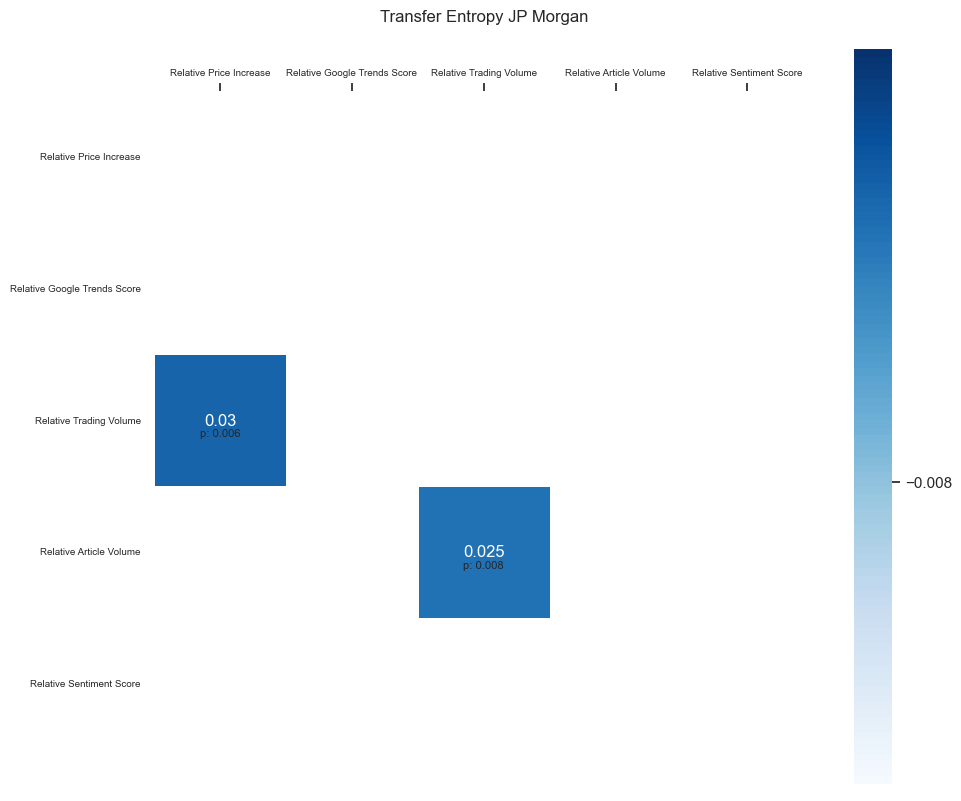

[[ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]]
[[ 0.003  0.013  0.001  0.01   0.005]
 [-0.005  0.008  0.013  0.     0.01 ]
 [ 0.008  0.018  0.021 -0.012 -0.003]
 [-0.004 -0.022 -0.003  0.006 -0.002]
 [ 0.004  0.014 -0.015  0.005 -0.009]]
[[0.37  0.131 0.45  0.203 0.337]
 [0.653 0.223 0.144 0.486 0.196]
 [0.236 0.068 0.029 0.842 0.577]
 [0.621 0.973 0.591 0.311 0.586]
 [0.344 0.127 0.899 0.355 0.811]]


C:\Users\franz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\franz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


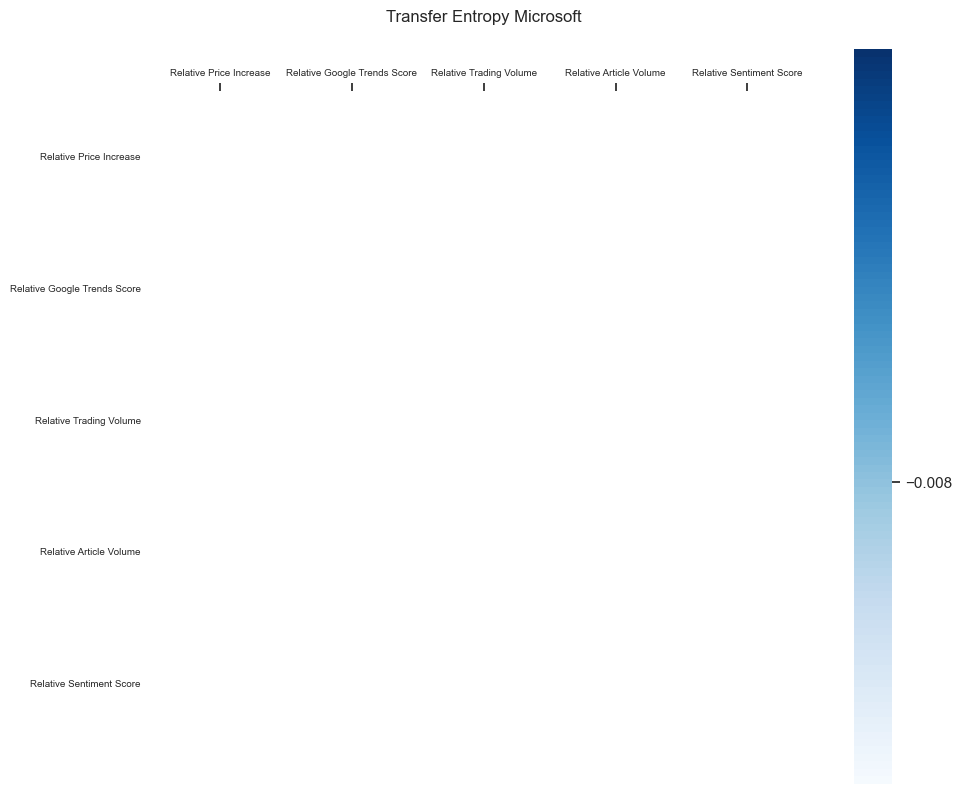

[[ True  True False  True  True]
 [ True  True  True  True False]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]]
[[ 0.005  0.013  0.02  -0.009  0.006]
 [-0.002  0.011 -0.006 -0.016  0.023]
 [ 0.009  0.013 -0.001 -0.007 -0.018]
 [-0.008 -0.005 -0.005  0.019  0.011]
 [ 0.013  0.005  0.002 -0.01  -0.028]]
[[0.331 0.13  0.048 0.783 0.292]
 [0.569 0.154 0.686 0.92  0.023]
 [0.232 0.103 0.53  0.722 0.943]
 [0.762 0.642 0.668 0.031 0.194]
 [0.153 0.327 0.457 0.789 0.99 ]]


[[ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]]
[[-0.008  0.002 -0.017 -0.006 -0.001]
 [ 0.014 -0.016 -0.007 -0.006  0.013]
 [-0.008 -0.006 -0.004 -0.004 -0.003]
 [-0.003 -0.008 -0.    -0.01   0.009]
 [ 0.002  0.001  0.    -0.006 -0.014]]
[[0.759 0.409 0.913 0.684 0.511]
 [0.128 0.932 0.728 0.7   0.13 ]
 [0.739 0.712 0.635 0.638 0.603]
 [0.634 0.764 0.511 0.792 0.198]
 [0.447 0.446 0.481 0.669 0.882]]


C:\Users\franz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\franz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


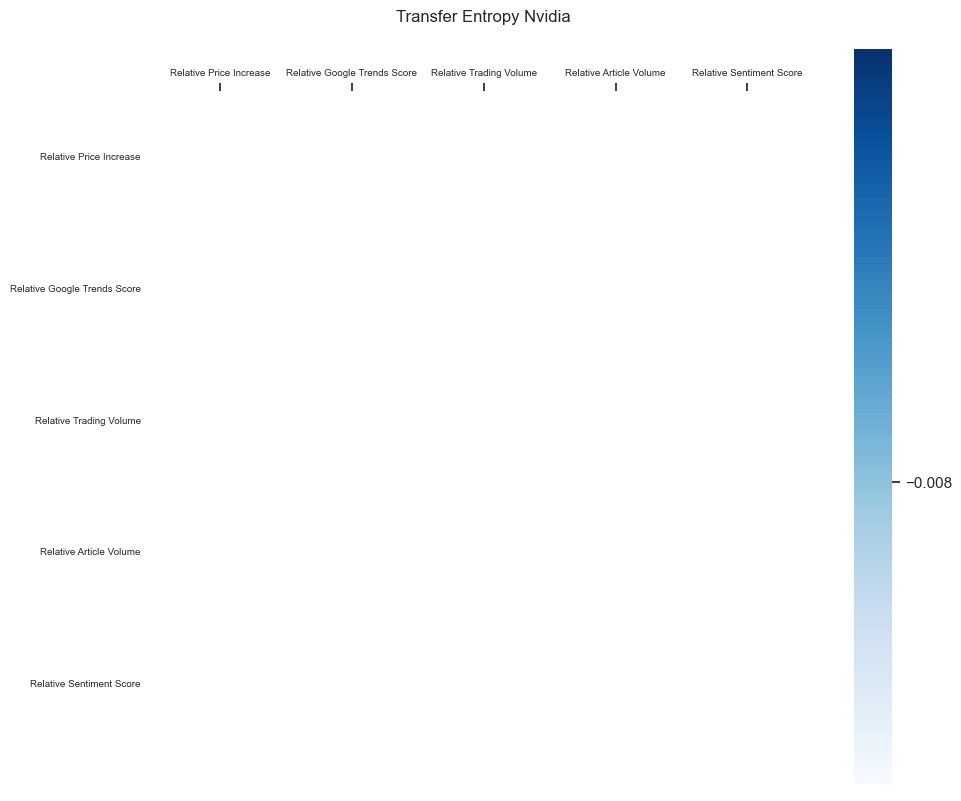

[[ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [False  True  True  True  True]
 [ True  True  True  True  True]]
[[-0.012 -0.013  0.011  0.    -0.004]
 [-0.015 -0.014  0.009  0.007 -0.001]
 [-0.004 -0.    -0.014 -0.007  0.003]
 [ 0.019  0.007 -0.013  0.008  0.014]
 [-0.026  0.009 -0.005 -0.002 -0.009]]
[[0.86  0.879 0.186 0.47  0.652]
 [0.926 0.895 0.189 0.284 0.53 ]
 [0.632 0.494 0.883 0.741 0.391]
 [0.049 0.272 0.871 0.229 0.114]
 [0.991 0.218 0.661 0.597 0.788]]


[[ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True False  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]]
[[-0.013 -0.011 -0.013  0.01   0.004]
 [ 0.011  0.02   0.013 -0.004  0.003]
 [-0.001 -0.005  0.005  0.021 -0.005]
 [-0.016  0.004 -0.006 -0.01   0.015]
 [ 0.009 -0.006 -0.007 -0.008 -0.014]]
[[0.846 0.835 0.86  0.166 0.312]
 [0.159 0.065 0.132 0.59  0.365]
 [0.539 0.671 0.328 0.031 0.606]
 [0.926 0.365 0.677 0.784 0.06 ]
 [0.225 0.697 0.748 0.729 0.879]]


In [18]:
from matplotlib.colors import Normalize, LinearSegmentedColormap
# set optimal parameters
parameters = [2,1,1,1,7]

# Define the Matrix Elements
# for every dataset
for i in range(len(data)):
    a_a = TE_X_to_Y_matrix(data[i][keys[0]], data[i][keys[0]],keys[0], keys[0], parameters)
    a_b = TE_X_to_Y_matrix(data[i][keys[0]], data[i][keys[1]],keys[0], keys[1], parameters)
    a_c = TE_X_to_Y_matrix(data[i][keys[0]], data[i][keys[2]],keys[0], keys[2], parameters)
    a_d = TE_X_to_Y_matrix(data[i][keys[0]], data[i][keys[3]],keys[0], keys[3], parameters)
    a_e = TE_X_to_Y_matrix(data[i][keys[0]], data[i][keys[4]],keys[0], keys[4], parameters)

    b_a = TE_X_to_Y_matrix(data[i][keys[1]], data[i][keys[0]],keys[1], keys[0], parameters)
    b_b = TE_X_to_Y_matrix(data[i][keys[1]], data[i][keys[1]],keys[1], keys[1], parameters)
    b_c = TE_X_to_Y_matrix(data[i][keys[1]], data[i][keys[2]],keys[1], keys[2], parameters)
    b_d = TE_X_to_Y_matrix(data[i][keys[1]], data[i][keys[3]],keys[1], keys[3], parameters)
    b_e = TE_X_to_Y_matrix(data[i][keys[1]], data[i][keys[4]],keys[1], keys[4], parameters)

    c_a = TE_X_to_Y_matrix(data[i][keys[2]], data[i][keys[0]],keys[2], keys[0], parameters)
    c_b = TE_X_to_Y_matrix(data[i][keys[2]], data[i][keys[1]],keys[2], keys[1], parameters)
    c_c = TE_X_to_Y_matrix(data[i][keys[2]], data[i][keys[2]],keys[2], keys[2], parameters)
    c_d = TE_X_to_Y_matrix(data[i][keys[2]], data[i][keys[3]],keys[2], keys[3], parameters)
    c_e = TE_X_to_Y_matrix(data[i][keys[2]], data[i][keys[4]],keys[2], keys[4], parameters)

    d_a = TE_X_to_Y_matrix(data[i][keys[3]], data[i][keys[0]],keys[3], keys[0], parameters)
    d_b = TE_X_to_Y_matrix(data[i][keys[3]], data[i][keys[1]],keys[3], keys[1], parameters)
    d_c = TE_X_to_Y_matrix(data[i][keys[3]], data[i][keys[2]],keys[3], keys[2], parameters)
    d_d = TE_X_to_Y_matrix(data[i][keys[3]], data[i][keys[3]],keys[3], keys[3], parameters)
    d_e = TE_X_to_Y_matrix(data[i][keys[3]], data[i][keys[4]],keys[3], keys[4], parameters)

    e_a = TE_X_to_Y_matrix(data[i][keys[4]], data[i][keys[0]],keys[4], keys[0], parameters)
    e_b = TE_X_to_Y_matrix(data[i][keys[4]], data[i][keys[1]],keys[4], keys[1], parameters)
    e_c = TE_X_to_Y_matrix(data[i][keys[4]], data[i][keys[2]],keys[4], keys[2], parameters)
    e_d = TE_X_to_Y_matrix(data[i][keys[4]], data[i][keys[3]],keys[4], keys[3], parameters)
    e_e = TE_X_to_Y_matrix(data[i][keys[4]], data[i][keys[4]],keys[4], keys[4], parameters)

    TE_values = np.array([
        [a_a[0], a_b[0], a_c[0], a_d[0], a_e[0]],
        [b_a[0], b_b[0], b_c[0], b_d[0], b_e[0]],
        [c_a[0], c_b[0], c_c[0], c_d[0], c_e[0]],
        [d_a[0], d_b[0], d_c[0], d_d[0], d_e[0]],
        [e_a[0], e_b[0], e_c[0], e_d[0], e_e[0]]
    ])

    TE_p_values = np.array([
        [a_a[1], a_b[1], a_c[1], a_d[1], a_e[1]],
        [b_a[1], b_b[1], b_c[1], b_d[1], b_e[1]],
        [c_a[1], c_b[1], c_c[1], c_d[1], c_e[1]],
        [d_a[1], d_b[1], d_c[1], d_d[1], d_e[1]],
        [e_a[1], e_b[1], e_c[1], e_d[1], e_e[1]]
    ])

    # Define mask matrix in order to hide cells where p-value is > 0.05
    mask_arr = TE_p_values > 0.05
    for x in range(len(mask_arr)):
        for y in range(len(mask_arr[0])):
            if x==y:
                mask_arr[x][y] = True
            
    print(mask_arr) 

    #Test Matrix to avoid long runtime
    """ TE_values = np.array([
        [-0.037,  0.02,   0.008, -0.005,  0.013],
        [ 0.006, -0.004,  0.014,  0.008,  0.01 ],
        [ 0.004,  0.017, -0.031,  0.019,  0.016],
        [-0.004,  0.02,  -0.004, -0.032,  0.004],
        [ 0.002,  0.014, -0.002, 0.014, -0.034]
    ])

    TE_p_values = np.array([
        [1., 0.011, 0.161, 0.715, 0.1  ],
        [0.252, 0.664, 0.054, 0.2,   0.155],
        [0.382, 0.032, 1.,    0.023, 0.036],
        [0.675, 0.017, 0.644, 0.999, 0.339],
        [0.437, 0.08,  0.592, 0.076, 1.   ]
    ])

    mask_arr = np.array([
        [True, False, False, False, False],
        [False, True, False, False, False],
        [False, False, True, False, False],
        [False, False, False, True, False],
        [False, False, False, False, True]
    ]) """

    print(TE_values)
    print(TE_p_values)

    


    # Define a custom color palette
    num_bins = 100
    blue_gradient = sns.color_palette("Blues", num_bins)
    blue_gradient.insert(0, (1, 1, 1))  # insert white at the beginning for -0.1
    custom_cmap_visible = LinearSegmentedColormap.from_list('custom_blue', blue_gradient, N=num_bins)
    norm = Normalize(vmin=-0.05, vmax=0.05)  # Normalizing from -0.05 to 0.05 (0.05 is a bit more than the highest TE value observed - setting it to a fixed value allows for more easy graphical interpretation among different stocks / crypto currenceis)

    # Plotting
    sns.set(style="white")
    plt.figure(figsize=(10, 8))
    heatmap = sns.heatmap(TE_values, mask=mask_arr, cmap=custom_cmap_visible, norm=norm, annot=True, xticklabels=keys, yticklabels=keys,
                        cbar_kws={"ticks": np.linspace(-0.1, 1, 13)}, linewidths=.5, square=True)
    heatmap.tick_params(axis='x', labelsize=7)
    heatmap.tick_params(axis='y', labelsize=7)  # Adjust fontsize for y-axis labels as well
    
    for x in range(TE_values.shape[0]):
        for y in range(TE_values.shape[1]):
            if TE_p_values[x][y] <= 0.05 and x!=y:
                plt.annotate(text="p: "+str(TE_p_values[x][y]), xy=(y+0.5 , x +0.6),  ha='center', va='center', fontsize=8)


    # Move the x-axis to the top of the figure
    heatmap.xaxis.tick_top()
    heatmap.xaxis.set_label_position('top')

    # Adjust the x-axis labels to be horizontal and for two lines
    plt.xticks(rotation=0, ha='center')
    plt.yticks(rotation=0)
    heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize=7)
    plt.tight_layout()

    plt.title(f'Transfer Entropy {asset_keyword[i]}', pad=50)

    # Show the plot
    plt.show()
